# Methods for Data Science: Course Work 2

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import scipy
from scipy.stats import multivariate_normal 
from scipy.sparse import linalg
from collections import defaultdict
from tqdm import tqdm
import networkx as nx

### Before Reading:

$\cdot$ specification about chunk order:

The order of the chunk might not be continuent from the start to the end. However, the order within each section is continuent and interrupting chunk number are added print-puts based on running chunks.

$\cdot$ About the use of sklearn in 2.1:

There is an import of sklearn, which has been used in 2.1 k-mean clustering. This is only for purpose of result checking. All the code in this notebook for assessment is written by elementary python functions or allowed packages.

Enjoy!

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

In this section, an MLP is built from scratch. For given activation functions, SGD is used as the optimization function and KL divergence as the loss function. Then the learning rate is adjusted to find the optimal one, and then the layer width is adjusted to find its effect on the model performance. As MLP wraps thousands of millions of parameters, dropout is used to regularize the network and to contruct a 'sub-network'. And the effect of such regularization on model performance isdiscussed through training nad test losses and accuracies.

A probablistic substitute for MLP is deep Gaussian process. In the last bit of the seesion, the histogram of the outcome of the first layer are plotted for both drop-out case and non-dropout case. And the effect of dropout is discussed from this perspective.

In [2]:
# load data and do some data processing
MNIST_train = pd.read_csv("MNIST_train.csv")
MNIST_test = pd.read_csv("MNIST_test.csv")
display(MNIST_train.head())
print("Shape of MNIST_train: ", MNIST_train.shape)
print("Shape of MNIST_test: ", MNIST_test.shape)

# convert to numpy array
MNIST_train = MNIST_train.to_numpy()
MNIST_test = MNIST_test.to_numpy()

# target-predictor split
x_train, y_train = MNIST_train[:,1:]/255, MNIST_train[:,0]
x_test, y_test = MNIST_test[:,1:]/255, MNIST_test[:,0]
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shape of MNIST_train:  (6000, 785)
Shape of MNIST_test:  (1000, 785)
Shape of x_train:  (6000, 784)
Shape of y_train:  (6000,)


In [3]:
MNIST_test[:, 1:][0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 242, 205,
        19,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  57, 242,
       253, 253, 166,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [4]:
# input layer
def flatten(x):
    return np.array([i.flatten() for i in x])

In [5]:
# softplus function
def softplus(x, beta=1):
    sp = np.log(1 + np.exp(beta*x)) / beta
    return sp

# derivative of softplus
def softplus_deriv(x, beta=1):
    return np.exp(beta*x) / (1 + np.exp(beta*x))

In [6]:
# softmax function
def softmax(x):
    y = np.exp(x) / np.sum(np.exp(x), axis=1)[..., np.newaxis]
    return y

In [7]:
# KL divergence loss function
def kl_loss(p, q):
    # Replace all zeros with a very small float (considering underflow issues)
    p[p == 0] = 1e-10
    q[q == 0] = 1e-10
    # return np.sum(p * np.log(p / q))/len(q)
    return np.sum(p * (np.log(p + 1e-8) - np.log(q + 1e-8)), axis=1)

In [8]:
# accuracy
def mlp_accuracy(y_pred, y_test):
    return np.mean(y_pred == y_test)

In [9]:
# prob vector to one single prediction
def mlp_prediction(y_pred):
    return np.argmax(y_pred, axis=1)

In [10]:
# compute the output error
def output_error(y_batch, a):
    y_pred = softmax(a)
    return y_pred - y_batch

In [11]:
# used to transform labels to probability distribution
def one_hot(Y):
    return np.eye(10)[Y]

In [12]:
# considering overfitting problems, use regularization technique
def dropout_mask(n, dropout_prob):
    return np.random.binomial(1, (1 - dropout_prob), size=n) / (1 - dropout_prob)

initialize parameters

In [13]:
# initialize the parameters: 3 hidden layers, each with 200 neurons; output layer with 10 neurons, one for each class
# use Glorot initialisation to initialize weights and bias 
def init_params(width=200):
    var0 = 2. / (784 + width)
    W1 = np.random.randn(784, width) * np.sqrt(var0)
    b1 = np.zeros(width)

    var1 = 2. / (width + width)
    W2 = np.random.randn(width, width) * np.sqrt(var1)
    b2 = np.zeros(width)
    var2 = 2. / (width + width)
    W3 = np.random.randn(width, width) * np.sqrt(var2)
    b3 = np.zeros(width)

    var3 = 2. / (10 + width)
    W4 = np.random.randn(width, 10) * np.sqrt(var3)
    b4 = np.zeros(10)
    
    return {'W1':W1,'W2':W2,'W3':W3,'W4':W4}, {'b1':b1,'b2':b2,'b3':b3,'b4':b4}

forward propogation

In [14]:
def forward_prop(x, weights, bias, dropout_prob=0):
    W1, W2, W3, W4 = weights.values()
    b1,b2,b3,b4 = bias.values()
    # input
    Z1 = np.dot(x,W1) + b1
    d1 = dropout_mask(Z1.shape,dropout_prob)
    A1 = softplus(Z1)
    A1 *= d1
    
    # hidden
    Z2 = np.dot(A1,W2) + b2
    d2 = dropout_mask(Z2.shape,dropout_prob)
    A2 = softplus(Z2)
    A2 *= d2
    Z3 = np.dot(A2,W3) + b3
    d3 = dropout_mask(Z3.shape,dropout_prob)
    A3 = softplus(Z3)
    A3 *= d3
    
    # output
    Z4 = np.dot(A3,W4) + b4
    A4 = softmax(Z4)
    
    return {'Z1': Z1,'Z2': Z2,'Z3': Z3,'Z4': Z4 },{'A1': A1, 'A2': A2,'A3': A3,'A4': A4}, {'d1':d1,'d2':d2,'d3':d3}

backward propagation

In [15]:
def backward_prop(x_batch, y_batch, outputs, weights, bias):
    m = y_batch.shape[0]
    Z1,Z2,Z3,Z4 = outputs[0].values()
    A1,A2,A3,A4 = outputs[1].values()
    d1,d2,d3 = outputs[2].values()
    W1, W2, W3, W4 = weights.values()
    b1,b2,b3,b4 = bias.values()
    
    dZ4 = A4 - one_hot(y_batch)
    dW4 = 1 / m * np.dot(dZ4.T,A3)
    db4 = 1 / m * np.sum(dZ4)
    
    dZ3 = np.dot(dZ4,W4.T) * softplus_deriv(Z3)
    dZ3 *= d3
    dW3 = 1 / m * np.dot(dZ3.T,A2)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = np.dot(dZ3,W3.T)* softplus_deriv(Z2)
    dZ2 *= d2
    dW2 = 1 / m * np.dot(dZ2.T,A1)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = np.dot(dZ2,W2.T) * softplus_deriv(Z1)
    dZ1 *= d1
    dW1 = 1 / m * np.dot(dZ1.T,x_batch)
    db1 = 1 / m * np.sum(dZ1)
    
    return {'dW4': dW4, 'db4': db4, 'dW3': dW3, 'db3': db3, 'dW2': dW2, 'db2': db2, 'dW1': dW1, 'db1': db1}

update the parameters (SGD)

In [16]:
def update_params(weights, bias, grads, lr):
    weights['W1'] -= lr * grads['dW1'].T
    weights['W2'] -= lr * grads['dW2'].T
    weights['W3'] -= lr * grads['dW3'].T
    weights['W4'] -= lr * grads['dW4'].T
    
    bias['b1'] -= lr * grads['db1']
    bias['b2'] -= lr * grads['db2']
    bias['b3'] -= lr * grads['db3']
    bias['b4'] -= lr * grads['db4']
       
    return weights, bias

MLP training

In [17]:
def train(x_train, y_train, x_test, y_test, lr, epochs, batch_size, width=200, dropout_prob=0):
    # initialization
    weights, bias = init_params(width=width)
    training_losses = []
    training_accuracies = []
    test_losses = []
    test_accuracies = []
    
    # sgd implementation
    for epoch in range(1, epochs+1):
        # shuffle
        indices = np.random.permutation(len(x_train))
        x_train = x_train[indices]
        y_train = y_train[indices]
        
        n_obs = x_train.shape[0]
        # a process bar to track the process
        progress_bar = tqdm(range(0, n_obs, batch_size), desc = f"Epoch {epoch}", unit = "batch", colour='green')
        count = 0

        # iterate through batches 
        for start in progress_bar:
            stop = start + batch_size
            x_batch, y_batch = x_train[start:stop], y_train[start:stop]
            
            forward_outputs = forward_prop(x_batch, weights, bias,dropout_prob)
            grads = backward_prop(x_batch, y_batch, forward_outputs, weights, bias)
            weights, bias = update_params(weights, bias, grads, lr)
        
            count += 1
            if count == len(progress_bar):
                # forward propogation
                forward_outputs_train = forward_prop(x_train, weights, bias)
                predictions_train = mlp_prediction(forward_outputs_train[1]['A4'])
                training_accuracy = mlp_accuracy(predictions_train, y_train)
                training_loss = np.mean(kl_loss(one_hot(y_train), one_hot(predictions_train)))
                
                # forward propagation on test set
                forward_outputs_test = forward_prop(x_test, weights, bias)
                predictions_test = mlp_prediction(forward_outputs_test[1]['A4'])
                test_accuracy =  mlp_accuracy(predictions_test, y_test)
                test_loss = np.mean(kl_loss(one_hot(y_test), one_hot(predictions_test)))
                
                # store on the lists
                training_losses.append(training_loss)
                training_accuracies.append(training_accuracy)
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
                
                progress_bar.set_postfix(train_loss = training_loss, train_accuracy = training_accuracy, test_loss = test_loss, test_accuracy = test_accuracy)

    return weights, bias, training_losses, training_accuracies,test_losses,test_accuracies

#### 1.1.1 Train MLP, with batch size of 128 and 40 epochs

In [18]:
lr = 0.18
epochs = 40
batch_size = 128

w,b, train_loss, train_acc, test_loss,test_acc = train(x_train, y_train, x_test, y_test, lr, epochs, batch_size)

Epoch 1: 100%|█| 47/47 [00:01<00:00, 36.78batch/s, test_accuracy=0.242, test_loss=14, train_accuracy=0.228, train_loss=
Epoch 2: 100%|█| 47/47 [00:01<00:00, 38.31batch/s, test_accuracy=0.588, test_loss=7.59, train_accuracy=0.596, train_los
Epoch 3: 100%|█| 47/47 [00:01<00:00, 40.14batch/s, test_accuracy=0.677, test_loss=5.95, train_accuracy=0.679, train_los
Epoch 4: 100%|█| 47/47 [00:01<00:00, 44.26batch/s, test_accuracy=0.82, test_loss=3.31, train_accuracy=0.815, train_loss
Epoch 5: 100%|█| 47/47 [00:01<00:00, 36.73batch/s, test_accuracy=0.831, test_loss=3.11, train_accuracy=0.823, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 40.75batch/s, test_accuracy=0.87, test_loss=2.39, train_accuracy=0.86, train_loss=
Epoch 7: 100%|█| 47/47 [00:01<00:00, 39.83batch/s, test_accuracy=0.872, test_loss=2.36, train_accuracy=0.868, train_los
Epoch 8: 100%|█| 47/47 [00:00<00:00, 47.74batch/s, test_accuracy=0.878, test_loss=2.25, train_accuracy=0.881, train_los
Epoch 9: 100%|█| 47/47 [00:00<00:00, 50.

In [19]:
# print train_loss
train_loss

[14.210015430141066,
 7.441003545258493,
 5.9037075550834395,
 3.4151904931433825,
 3.258699284562688,
 2.577502258976138,
 2.427147960535863,
 2.193945375199927,
 1.8287992218449738,
 1.629349642281344,
 1.6631026480536508,
 1.365462506243311,
 1.7275402045280541,
 2.2307668360424424,
 1.4329685177879243,
 1.119986100626536,
 1.3808047815943594,
 1.0555485441521326,
 1.0217955383798258,
 1.0064532630287777,
 1.6048020017196665,
 1.2243135730136654,
 1.0954384600648586,
 0.816209048675777,
 0.8254144138864059,
 0.7425661269907444,
 0.7180184864290668,
 0.6627862951652925,
 1.1107807354159072,
 0.5830064633398406,
 0.7026762110780186,
 1.5679805408771506,
 0.46640517067187254,
 0.5768695531994212,
 0.4357206199697756,
 0.5492534575675341,
 0.4848159010931306,
 0.500158176444179,
 0.49095281123355,
 0.23013413026572657]

In [20]:
# set different learning rates
learning_rates = np.logspace(-4, 0, 7)
epochs = 40
batch_size = 128

train_losses = []
test_losses = []
for learning_rate in learning_rates:
    print(f'Training MLP for learning rate = {learning_rate}')
    w,b, train_loss, train_acc, test_loss,test_acc = train(x_train, y_train, x_test, y_test, learning_rate, epochs,batch_size)
    # record the final loss
    train_losses.append(train_loss[-1])
    test_losses.append(test_loss[-1])

Training MLP for learning rate = 0.0001


Epoch 1: 100%|█| 47/47 [00:01<00:00, 42.42batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 2: 100%|█| 47/47 [00:01<00:00, 44.39batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 3: 100%|█| 47/47 [00:01<00:00, 34.45batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 4: 100%|█| 47/47 [00:03<00:00, 11.90batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 5: 100%|█| 47/47 [00:02<00:00, 20.31batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 6: 100%|█| 47/47 [00:01<00:00, 25.36batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 7: 100%|█| 47/47 [00:02<00:00, 20.49batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 8: 100%|█| 47/47 [00:02<00:00, 22.41batch/s, test_accuracy=0.098, test_loss=16.6, train_accuracy=0.0985, train_lo
Epoch 9: 100%|█| 47/47 [00:01<00:00, 30.

Training MLP for learning rate = 0.00046415888336127773


Epoch 1: 100%|█| 47/47 [00:01<00:00, 35.19batch/s, test_accuracy=0.099, test_loss=16.6, train_accuracy=0.0983, train_lo
Epoch 2: 100%|█| 47/47 [00:01<00:00, 35.87batch/s, test_accuracy=0.094, test_loss=16.7, train_accuracy=0.0948, train_lo
Epoch 3: 100%|█| 47/47 [00:01<00:00, 35.33batch/s, test_accuracy=0.094, test_loss=16.7, train_accuracy=0.0918, train_lo
Epoch 4: 100%|█| 47/47 [00:01<00:00, 35.57batch/s, test_accuracy=0.106, test_loss=16.5, train_accuracy=0.105, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 35.37batch/s, test_accuracy=0.109, test_loss=16.4, train_accuracy=0.117, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 35.05batch/s, test_accuracy=0.123, test_loss=16.1, train_accuracy=0.122, train_los
Epoch 7: 100%|█| 47/47 [00:01<00:00, 37.60batch/s, test_accuracy=0.136, test_loss=15.9, train_accuracy=0.122, train_los
Epoch 8: 100%|█| 47/47 [00:01<00:00, 35.84batch/s, test_accuracy=0.136, test_loss=15.9, train_accuracy=0.132, train_los
Epoch 9: 100%|█| 47/47 [00:01<00:00, 33.

Training MLP for learning rate = 0.002154434690031882


Epoch 1: 100%|█| 47/47 [00:00<00:00, 47.78batch/s, test_accuracy=0.079, test_loss=17, train_accuracy=0.0878, train_loss
Epoch 2: 100%|█| 47/47 [00:00<00:00, 48.03batch/s, test_accuracy=0.134, test_loss=15.9, train_accuracy=0.125, train_los
Epoch 3: 100%|█| 47/47 [00:01<00:00, 46.49batch/s, test_accuracy=0.157, test_loss=15.5, train_accuracy=0.148, train_los
Epoch 4: 100%|█| 47/47 [00:00<00:00, 48.24batch/s, test_accuracy=0.229, test_loss=14.2, train_accuracy=0.223, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 45.99batch/s, test_accuracy=0.259, test_loss=13.6, train_accuracy=0.254, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 42.33batch/s, test_accuracy=0.285, test_loss=13.2, train_accuracy=0.287, train_los
Epoch 7: 100%|█| 47/47 [00:02<00:00, 16.35batch/s, test_accuracy=0.337, test_loss=12.2, train_accuracy=0.33, train_loss
Epoch 8: 100%|█| 47/47 [00:02<00:00, 21.64batch/s, test_accuracy=0.337, test_loss=12.2, train_accuracy=0.332, train_los
Epoch 9: 100%|█| 47/47 [00:01<00:00, 29.

Training MLP for learning rate = 0.01


Epoch 1: 100%|█| 47/47 [00:00<00:00, 50.50batch/s, test_accuracy=0.194, test_loss=14.8, train_accuracy=0.193, train_los
Epoch 2: 100%|█| 47/47 [00:00<00:00, 48.89batch/s, test_accuracy=0.179, test_loss=15.1, train_accuracy=0.186, train_los
Epoch 3: 100%|█| 47/47 [00:01<00:00, 38.61batch/s, test_accuracy=0.433, test_loss=10.4, train_accuracy=0.428, train_los
Epoch 4: 100%|█| 47/47 [00:01<00:00, 45.37batch/s, test_accuracy=0.474, test_loss=9.68, train_accuracy=0.485, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 45.85batch/s, test_accuracy=0.546, test_loss=8.36, train_accuracy=0.536, train_los
Epoch 6: 100%|█| 47/47 [00:00<00:00, 48.28batch/s, test_accuracy=0.562, test_loss=8.06, train_accuracy=0.568, train_los
Epoch 7: 100%|█| 47/47 [00:00<00:00, 49.49batch/s, test_accuracy=0.559, test_loss=8.12, train_accuracy=0.538, train_los
Epoch 8: 100%|█| 47/47 [00:00<00:00, 47.27batch/s, test_accuracy=0.631, test_loss=6.79, train_accuracy=0.636, train_los
Epoch 9: 100%|█| 47/47 [00:00<00:00, 48.

Training MLP for learning rate = 0.046415888336127774


Epoch 1: 100%|█| 47/47 [00:00<00:00, 50.65batch/s, test_accuracy=0.152, test_loss=15.6, train_accuracy=0.151, train_los
Epoch 2: 100%|█| 47/47 [00:00<00:00, 49.92batch/s, test_accuracy=0.337, test_loss=12.2, train_accuracy=0.33, train_loss
Epoch 3: 100%|█| 47/47 [00:00<00:00, 51.43batch/s, test_accuracy=0.618, test_loss=7.03, train_accuracy=0.62, train_loss
Epoch 4: 100%|█| 47/47 [00:00<00:00, 49.22batch/s, test_accuracy=0.578, test_loss=7.77, train_accuracy=0.578, train_los
Epoch 5: 100%|█| 47/47 [00:00<00:00, 50.35batch/s, test_accuracy=0.796, test_loss=3.76, train_accuracy=0.789, train_los
Epoch 6: 100%|█| 47/47 [00:00<00:00, 49.76batch/s, test_accuracy=0.711, test_loss=5.32, train_accuracy=0.71, train_loss
Epoch 7: 100%|█| 47/47 [00:00<00:00, 51.60batch/s, test_accuracy=0.791, test_loss=3.85, train_accuracy=0.8, train_loss=
Epoch 8: 100%|█| 47/47 [00:00<00:00, 50.46batch/s, test_accuracy=0.864, test_loss=2.5, train_accuracy=0.864, train_loss
Epoch 9: 100%|█| 47/47 [00:00<00:00, 51.

Training MLP for learning rate = 0.21544346900318823


Epoch 1: 100%|█| 47/47 [00:02<00:00, 21.76batch/s, test_accuracy=0.195, test_loss=14.8, train_accuracy=0.192, train_los
Epoch 2: 100%|█| 47/47 [00:01<00:00, 27.31batch/s, test_accuracy=0.415, test_loss=10.8, train_accuracy=0.406, train_los
Epoch 3: 100%|█| 47/47 [00:01<00:00, 30.72batch/s, test_accuracy=0.659, test_loss=6.28, train_accuracy=0.652, train_los
Epoch 4: 100%|█| 47/47 [00:01<00:00, 31.26batch/s, test_accuracy=0.759, test_loss=4.44, train_accuracy=0.765, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 33.99batch/s, test_accuracy=0.813, test_loss=3.44, train_accuracy=0.806, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 34.58batch/s, test_accuracy=0.855, test_loss=2.67, train_accuracy=0.864, train_los
Epoch 7: 100%|█| 47/47 [00:01<00:00, 34.80batch/s, test_accuracy=0.876, test_loss=2.28, train_accuracy=0.881, train_los
Epoch 8: 100%|█| 47/47 [00:01<00:00, 34.06batch/s, test_accuracy=0.855, test_loss=2.67, train_accuracy=0.853, train_los
Epoch 9: 100%|█| 47/47 [00:01<00:00, 29.

Training MLP for learning rate = 1.0


Epoch 1: 100%|█| 47/47 [00:00<00:00, 48.34batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 2: 100%|█| 47/47 [00:00<00:00, 48.87batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 3: 100%|█| 47/47 [00:01<00:00, 44.84batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 4: 100%|█| 47/47 [00:00<00:00, 47.70batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 5: 100%|█| 47/47 [00:00<00:00, 49.57batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 6: 100%|█| 47/47 [00:00<00:00, 48.61batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 7: 100%|█| 47/47 [00:00<00:00, 47.60batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 8: 100%|█| 47/47 [00:01<00:00, 46.72batch/s, test_accuracy=0.1, test_loss=16.6, train_accuracy=0.1, train_loss=16
Epoch 9: 100%|█| 47/47 [00:00<00:00, 47.

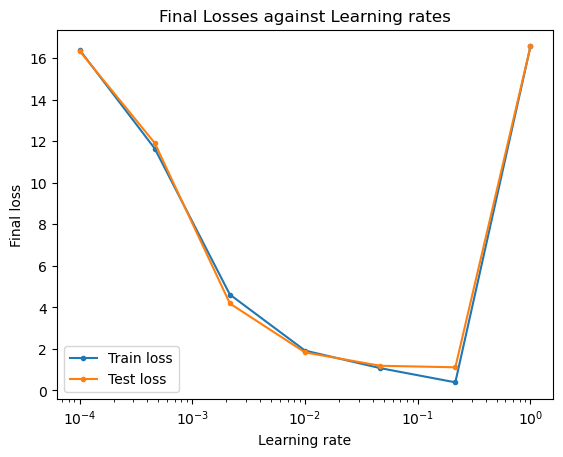

In [21]:
# plotting
plt.plot(learning_rates, train_losses,'.-',label='Train loss')
plt.plot(learning_rates, test_losses,'.-',label='Test loss')

plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Final loss')
plt.title('Final Losses against Learning rates')
plt.legend()
plt.show()

# Explanation:

In finding the relations between the losses and the learning rate, options for learning rates from $10^{-4}$ to $10^{0}$ are split into 7 points at equal distance.

From the plot, the final loss at `epoch=40` for both train and test data have a decreasing trend, meaning that a too small learning rate ($lr$) is getting close but not enough to converge to the optimal point.

However, the loss explodes in the final bit, meaning that a big step makes the final loss sway unstablely around the optimal point and hardly converges to the optimal point.

Optimal learning rate should be set at a value where both the train loss is minimal in the restricted interval and right before the test loss is exploding.

Note that this doesn't imply any information about overfitting or underfitting.

#### 1.1.2 Train the MLP at optimal learning rate found in 1.1.1. Use loss and accuracy to be the model measure.

In [22]:
best_lr = learning_rates[-2]
print("Best learning rate:", best_lr)

epochs = 40
batch_size = 128

best_w,best_b, best_train_loss, best_train_acc, best_test_loss, best_test_acc = train(x_train, y_train, x_test, y_test, best_lr, epochs,batch_size)

Best learning rate: 0.21544346900318823


Epoch 1: 100%|█| 47/47 [00:01<00:00, 46.95batch/s, test_accuracy=0.121, test_loss=16.2, train_accuracy=0.13, train_loss
Epoch 2: 100%|█| 47/47 [00:01<00:00, 43.55batch/s, test_accuracy=0.359, test_loss=11.8, train_accuracy=0.356, train_los
Epoch 3: 100%|█| 47/47 [00:01<00:00, 45.47batch/s, test_accuracy=0.545, test_loss=8.38, train_accuracy=0.536, train_los
Epoch 4: 100%|█| 47/47 [00:01<00:00, 46.50batch/s, test_accuracy=0.602, test_loss=7.33, train_accuracy=0.584, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 44.83batch/s, test_accuracy=0.719, test_loss=5.17, train_accuracy=0.723, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 46.84batch/s, test_accuracy=0.783, test_loss=4, train_accuracy=0.777, train_loss=4
Epoch 7: 100%|█| 47/47 [00:01<00:00, 46.47batch/s, test_accuracy=0.854, test_loss=2.69, train_accuracy=0.859, train_los
Epoch 8: 100%|█| 47/47 [00:00<00:00, 47.17batch/s, test_accuracy=0.858, test_loss=2.61, train_accuracy=0.865, train_los
Epoch 9: 100%|█| 47/47 [00:01<00:00, 30.

In [23]:
# print best_train_loss
best_train_loss

[16.02347237663499,
 11.856510391290234,
 8.54257891546377,
 7.668069220454009,
 5.102840781758711,
 4.111729794080982,
 2.6051183546080248,
 2.4885170619400565,
 1.9699481550746192,
 2.0681387173213293,
 1.9515374246533614,
 1.7490193900195217,
 1.6324180973515536,
 1.5465013553856826,
 1.6446919176323926,
 1.1476021962584233,
 1.3623940511731014,
 1.1107807354159072,
 1.5986650915792473,
 1.0524800890819228,
 1.8686891377576997,
 0.9021257906416481,
 0.8775781500799706,
 0.7732506776928413,
 0.8898519703608094,
 0.8008667733247284,
 1.1322599209073747,
 0.9819056224671,
 0.865304329799132,
 0.6996077560078087,
 0.7425661269907444,
 0.7855244979736801,
 0.4449259851804047,
 0.5277742720760663,
 0.5768695531994212,
 0.4173098895485175,
 0.32218778237201723,
 0.4019676141974691,
 0.27309250124866224,
 0.30377705195075905]

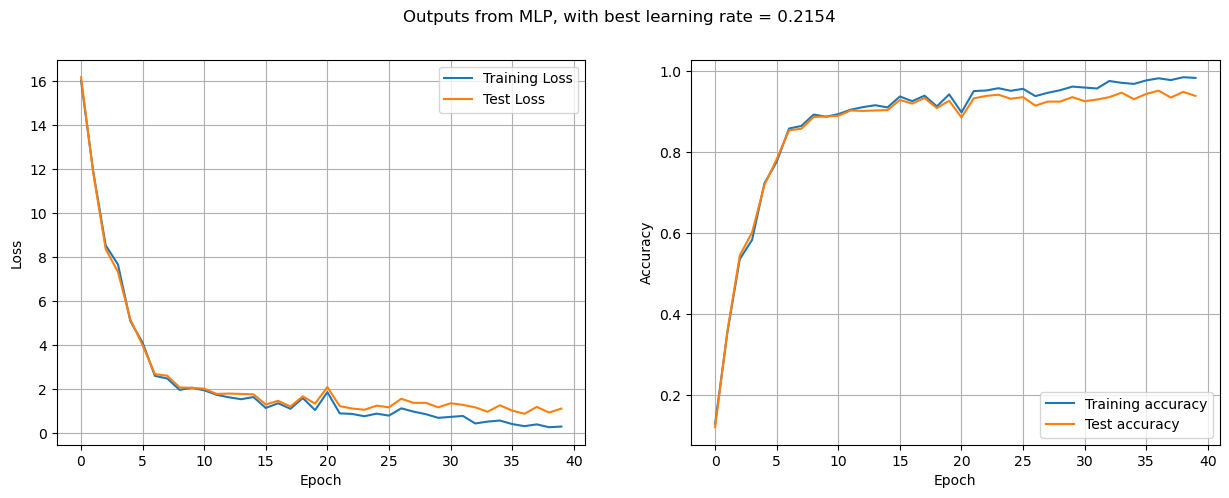

In [24]:
# plotting
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(range(epochs),best_train_loss,label=f'Training Loss')
ax1.plot(range(epochs),best_test_loss,label=f'Test Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid()

ax2.plot(range(epochs),best_train_acc,label=f'Training accuracy')
ax2.plot(range(epochs),best_test_acc,label=f'Test accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid()

ax1.legend()
ax2.legend()
plt.suptitle(f"Outputs from MLP, with best learning rate = {best_lr:.4f}")
plt.show()

In [25]:
### adding the print-outs of final losses
print("The final losses of training and test data are: ",best_train_loss[-1], best_test_loss[-1], "repectively.")
print("The final accuracies of training and test data are: ",best_train_acc[-1], best_test_acc[-1], "repectively.")

The final losses of training and test data are:  0.30377705195075905 1.1230545556967457 repectively.
The final accuracies of training and test data are:  0.9835 0.939 repectively.


#### 1.1.3 train the MLP with reduced width of layers: 50 neurons

In [26]:
# retrain using optimal learning rate
best_lr = learning_rates[np.argmin(train_losses)]

width = 50
epochs=40
batch_size = 128

best_w_2,best_b_2, best_train_loss_2, best_train_acc_2, best_test_loss_2,best_test_acc_2 = train(x_train, y_train, x_test, y_test, best_lr, epochs, width=width, batch_size= batch_size)

Epoch 1: 100%|█| 47/47 [00:00<00:00, 168.91batch/s, test_accuracy=0.459, test_loss=9.96, train_accuracy=0.452, train_lo
Epoch 2: 100%|█| 47/47 [00:00<00:00, 141.95batch/s, test_accuracy=0.673, test_loss=6.02, train_accuracy=0.677, train_lo
Epoch 3: 100%|█| 47/47 [00:00<00:00, 143.24batch/s, test_accuracy=0.649, test_loss=6.46, train_accuracy=0.648, train_lo
Epoch 4: 100%|█| 47/47 [00:00<00:00, 161.75batch/s, test_accuracy=0.852, test_loss=2.72, train_accuracy=0.864, train_lo
Epoch 5: 100%|█| 47/47 [00:00<00:00, 166.55batch/s, test_accuracy=0.873, test_loss=2.34, train_accuracy=0.881, train_lo
Epoch 6: 100%|█| 47/47 [00:00<00:00, 151.04batch/s, test_accuracy=0.885, test_loss=2.12, train_accuracy=0.891, train_lo
Epoch 7: 100%|█| 47/47 [00:00<00:00, 161.94batch/s, test_accuracy=0.903, test_loss=1.79, train_accuracy=0.913, train_lo
Epoch 8: 100%|█| 47/47 [00:00<00:00, 162.50batch/s, test_accuracy=0.914, test_loss=1.58, train_accuracy=0.92, train_los
Epoch 9: 100%|█| 47/47 [00:00<00:00, 165

In [27]:
# print best_train_loss_2
best_train_loss_2

[10.098285636060082,
 5.946665926066375,
 6.47750865321265,
 2.513064702501734,
 2.1816715549190877,
 2.000632705776716,
 1.5925281814388281,
 1.4697899786304403,
 1.5649120858069405,
 1.5188852597537956,
 1.3040934048391173,
 1.6446919176323926,
 1.1997659324519878,
 0.9450841616245838,
 0.9880425326075194,
 0.816209048675777,
 0.8560989645885029,
 0.6535809299546634,
 0.6474440198142442,
 0.6014171937610987,
 1.3531886859624722,
 0.6259648343227762,
 1.8287992218449738,
 0.5032266315143887,
 0.3927622489868399,
 0.4111729794080981,
 0.432652164899566,
 0.4203783446187272,
 0.2915032316699203,
 0.26388713603803315,
 0.2792294113890816,
 0.2516133157571944,
 0.34673542293369475,
 0.15955966365090377,
 0.11966974773817782,
 0.23933949547635563,
 0.11046438252754877,
 0.20251803463383938,
 0.12887511294880688,
 0.05830064633398407]

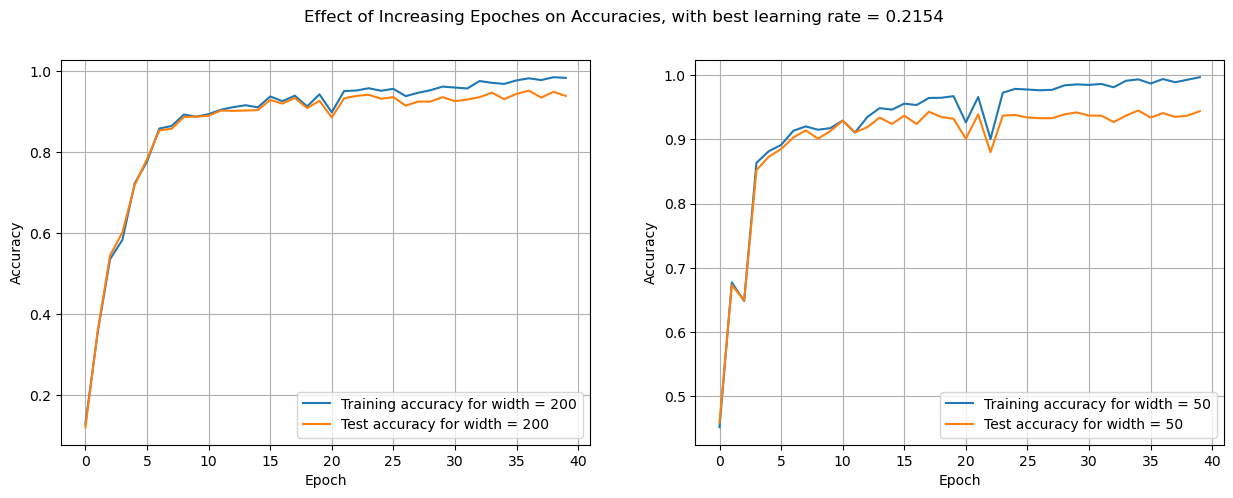

For width = 200:
Final Train Accuracy:  0.9835
Final Test Accuracy:  0.939

For width = 50:
Final Train Accuracy:  0.9968333333333333
Final Test Accuracy:  0.944


In [28]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(range(40),best_train_acc,label=f'Training accuracy for width = 200')
ax1.plot(range(40),best_test_acc,label=f'Test accuracy for width = 200')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.grid()

ax2.plot(range(40),best_train_acc_2,label=f'Training accuracy for width = 50')
ax2.plot(range(40),best_test_acc_2,label=f'Test accuracy for width = 50')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid()

ax1.legend()
ax2.legend()
plt.suptitle(f"Effect of Increasing Epoches on Accuracies, with best learning rate = {best_lr:.4f}")
plt.show()

print("For width = 200:")
print("Final Train Accuracy: ", best_train_acc[-1])
print("Final Test Accuracy: ", best_test_acc[-1])
print("\nFor width = 50:")
print("Final Train Accuracy: ", best_train_acc_2[-1])
print("Final Test Accuracy: ", best_test_acc_2[-1])

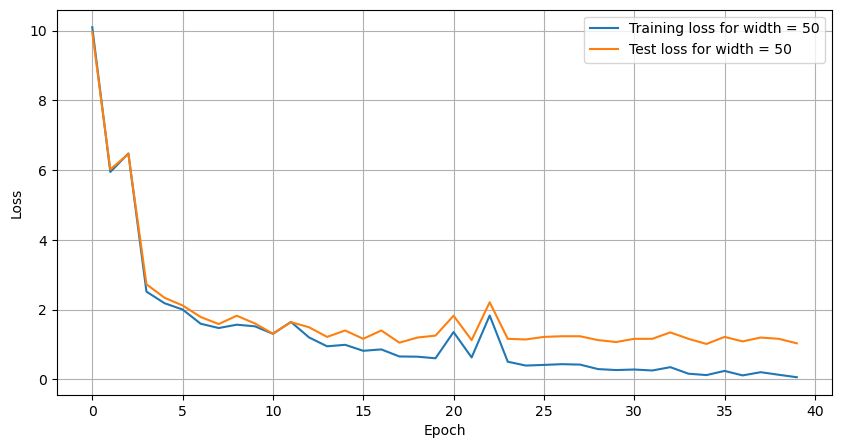

The final losses of training and test data are:  0.05830064633398407 1.031000903590455 repectively.


In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(40), best_train_loss_2, label=f'Training loss for width = 50')
ax.plot(range(40), best_test_loss_2, label=f'Test loss for width = 50')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid()
ax.legend()
plt.show()

print("The final losses of training and test data are: ",best_train_loss_2[-1], best_test_loss_2[-1], "repectively.")

# Explanation:

The width of a hidden layer refers to the number of neurons or units in that layer. Similar to the model complexity for linear regression, the more neurons per layer, the more complex patterns the MLP can learn from the data.

From the print-outs, the final loss for the training and test data set are both higher for reduced-width model. This could mean that the model in 1.2.2 performs better, with better fitted test data. In addition, it can be observed that the accuracies of training data and test data are closer to each other. This indicates that model in 1.2.2 fits the unseen data better

However, for both models, the accuracies for the training and test data are increasing, but the accuracies for training and particularly the test data remains stable at `width=50`. This could be the model with reduced part has had converged.

Given more time, a tolerance can be set to return a signal once the test accuracy and test loss falls within certain criterion for both models.

#### 1.1.4 Retrain MLP with dropout rate (regularization)

In [30]:
# retrain MLP using optimal learning rate
# retrain using optimal learning rate

lr = learning_rates[np.argmin(train_losses)]
epochs = 50  # scaled epochs
batch_size = 128
dropout_prob = 0.2

w_dropout,b_dropout,train_loss_dropout, train_acc_dropout,test_loss_dropout,test_acc_dropout = train(x_train, y_train, x_test, y_test, lr, epochs,batch_size,dropout_prob=dropout_prob)

Epoch 1: 100%|█| 47/47 [00:01<00:00, 45.84batch/s, test_accuracy=0.134, test_loss=15.9, train_accuracy=0.131, train_los
Epoch 2: 100%|█| 47/47 [00:01<00:00, 46.44batch/s, test_accuracy=0.403, test_loss=11, train_accuracy=0.404, train_loss=
Epoch 3: 100%|█| 47/47 [00:01<00:00, 45.38batch/s, test_accuracy=0.69, test_loss=5.71, train_accuracy=0.692, train_loss
Epoch 4: 100%|█| 47/47 [00:01<00:00, 45.08batch/s, test_accuracy=0.721, test_loss=5.14, train_accuracy=0.735, train_los
Epoch 5: 100%|█| 47/47 [00:01<00:00, 46.80batch/s, test_accuracy=0.845, test_loss=2.85, train_accuracy=0.841, train_los
Epoch 6: 100%|█| 47/47 [00:01<00:00, 46.83batch/s, test_accuracy=0.848, test_loss=2.8, train_accuracy=0.85, train_loss=
Epoch 7: 100%|█| 47/47 [00:01<00:00, 46.55batch/s, test_accuracy=0.882, test_loss=2.17, train_accuracy=0.876, train_los
Epoch 8: 100%|█| 47/47 [00:01<00:00, 46.68batch/s, test_accuracy=0.888, test_loss=2.06, train_accuracy=0.888, train_los
Epoch 9: 100%|█| 47/47 [00:00<00:00, 48.

In [31]:
# print train_loss with drop-out rates
print(train_loss_dropout)

[16.001993191143523, 10.98200069628047, 5.673573424817713, 4.888048926844032, 2.9273061369800417, 2.767746473329138, 2.285999027306217, 2.0681387173213293, 2.0865494477425877, 1.9576743347937808, 1.9085790536704257, 1.8073200363535058, 1.6354865524217632, 1.5311590800346342, 1.5802543611579891, 1.3623940511731012, 1.4851322539814888, 1.3930786018751982, 1.3439833207518432, 1.2488612135753427, 1.356257141032682, 1.1874921121711492, 1.0616854542925518, 1.1046438252754875, 1.1261230107669553, 1.101575370205278, 0.9573579819054225, 0.9849740775373096, 0.9420157065543742, 0.9113311558522773, 0.865304329799132, 0.8622358747289223, 0.8376882341672447, 0.834619779097035, 0.892920425431019, 0.7701822226226317, 0.718018486429067, 0.8254144138864061, 0.68733393572697, 0.6904023907971797, 0.7241553965694862, 0.6689232053057119, 0.6413071096738248, 0.6535809299546635, 0.6044856488313084, 0.5492534575675341, 0.5553903677079536, 0.5922118285504697, 0.5431165474271147, 0.5277742720760663]


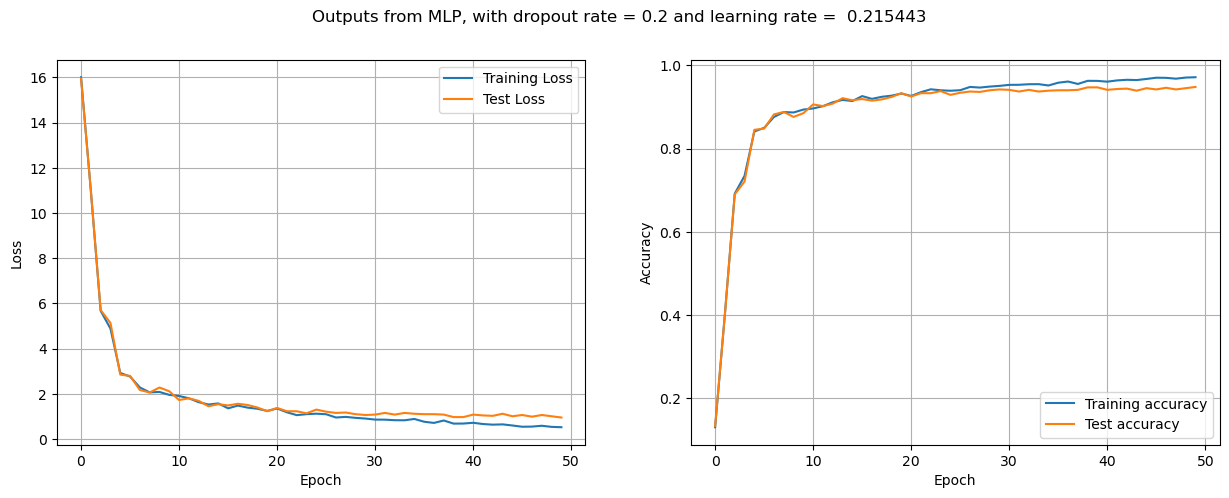

Final Dropout Train Loss:  0.5277742720760663
Final Dropout Test Loss:  0.9573579819054225
Final without Dropout Train Accuracy:  0.9713333333333334
Final without Dropout Test Accuracy:  0.948


In [32]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(range(epochs),train_loss_dropout,label=f'Training Loss')
ax1.plot(range(epochs),test_loss_dropout,label=f'Test Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid()

ax2.plot(range(epochs),train_acc_dropout,label=f'Training accuracy')
ax2.plot(range(epochs),test_acc_dropout,label=f'Test accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid()

ax1.legend()
ax2.legend()
plt.suptitle(f"Outputs from MLP, with dropout rate = {dropout_prob} and learning rate = {lr: 4f}")
plt.show()

print("Final Dropout Train Loss: ", train_loss_dropout[-1])
print("Final Dropout Test Loss: ", test_loss_dropout[-1])
print("Final Dropout Train Accuracy: ", train_acc_dropout[-1])
print("Final Dropout Test Accuracy: ", test_acc_dropout[-1])

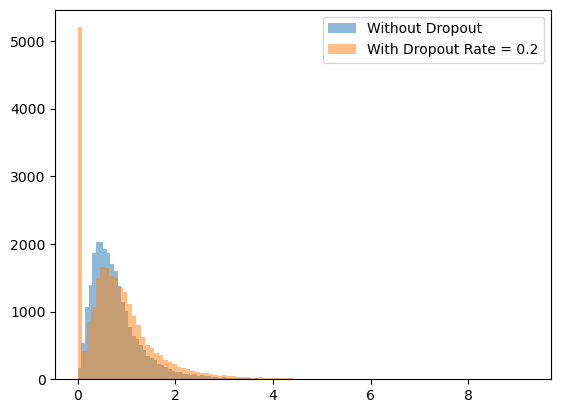

Sum of activations in MLP without dropout:  20555.677530687786
Sum of activations in MLP with dropout rate = 0.2:  20618.161134698887

Percentage of zero in activations with dropout: 19.78125 %


In [33]:
# the first batch
x_batch_test = x_test[:128]

# no dropout
outputs_nd = forward_prop(x_batch_test, best_w, best_b)

# with dropout = 0.2
outputs_d = forward_prop(x_batch_test, best_w, best_b, dropout_prob = 0.2)

# plotting activations of the first hidden layer
activations_nd = outputs_nd[1]['A1'].flatten()
activations_d = outputs_d[1]['A1'].flatten()

plt.hist(outputs_nd[1]['A1'].flatten(), bins=100, density=False, alpha=0.5, label="Without Dropout")
plt.hist(outputs_d[1]['A1'].flatten(), bins=100, density=False, alpha=0.5, label="With Dropout Rate = 0.2")
plt.legend()
plt.show()

print("Sum of activations in MLP without dropout: ", np.sum(outputs_nd[1]['A1']))
print("Sum of activations in MLP with dropout rate = 0.2: ", np.sum(outputs_d[1]['A1']))

print("\nPercentage of zero in activations with dropout:", (len(activations_d[activations_d<1e-10])/len(activations_d))*100,'%')

# Expanation:

- Effect of dropout:

Dropout is a technique of regularization to prevent overfitting. It randomly replaces elemts of each col of $W$ with zeros with `dropout_prob`. By doing this, the capacity of the model is reduced and it prevents the neurons from co-adapting each other too much. Neurons in the network have less dependence on other specific neurons being present, and so each neuron learns features that are more robust, and generalises better.

- In terms of loss and accuracy plots:

It can be observed from the plots without doubt that the model performs better with dropout:

$\cdot$ less fluctuating losses and accuracies,

$\cdot$ much narrower gaps for training and test data from smaller epochs onwards and,

$\cdot$ higher test accuracies(from $\boldsymbol {0.939}$ to $\boldsymbol {0.948}$). 

They indicate that the model reduces disruption of noise and could have converged, and the model generalizes more robustly to unseen data. 

- Comparison between the histograms:

References: http://proceedings.mlr.press/v48/gal16.pdf    http://proceedings.mlr.press/v31/damianou13a.pdf


The histogram with dropout is more Gaussian distributed than that without dropout. This can be interpreted in terms of Deep Gaussian process:

Deep Gaussian process is a probablistic substitute for MLP. And in the scenario of this part, the MLP with 1 hidden layer is equivalent to a standard Gaussian process (from refs). 

The approach to Gaussian process modelling is to place a prior directly over a class of functions and integrate them out. In MLP, dropping-out can be viewed as a Baysian model averaging, which processes inputs into subsets of neurons and are corresponding to non-zero assignments of Bernoulli mask. By doing so, dropout can reduce the co-adapting of the network on individual neurons, making it learn more distributed representations. This latter is analogous to the former, in the way that a Gaussian process places a prior over functions, encouraging them to be smooth and avoiding overfitting to noisy data.

Therefore, using dropout, the first hidden layer activations is more like a Gaussian process, with smooth and well-behaved functions that generalize well to new data. This corresponds to the behaviour of the orange histogram (without considerations of dropped zeros). And a better generalization corresponds to the trend shown in the loss and accuracy plots.

--------------------------------------------------------------------------------------------------------------------------------

#### 1.2 Dimensionality reduction (20 marks)

For various applications of NMF and PCA, denoising is applied in this section.

For given image matrices, PCA is implemented to see the trend of variance explained by principle components (eigenvectors of the matrix) and for both methods, the first 10 basis components are visualized and differences are explained.

Due to the different natures of the decomposition approaches, effects of denoising for 100 pc are discussed for both methods by reconstructed images. One important thing to notice is that: in the process of training, noisy images have been normalized by first being divided by 255 and then by standard procedure of standardization. Therefore, to compare reconstructed images and original noisy and unnoisy images, reconstructed images should be reverted back by multiplying 'sigma' and adding 'mu' stored ealier. After this step, all images are at the same scale.

Finally, MSE is used as a measure of performance of PCA to see how it behaves wrt the test noisy data and the unnoisy data. Similarly, the reconsrtructed images should be reverted to its original scale by the same steps mentioned above.

In [34]:
# read txt file
MNIST_train_noisy = np.loadtxt('MNIST_train_noisy.txt')
MNIST_test_noisy = np.loadtxt('MNIST_test_noisy.txt')

# inspecting the data
print("The shapes of the training and test data are: ", MNIST_train_noisy.shape, MNIST_test_noisy.shape)
print("The type of the MNIST_train_noisy and MNIST_test_noisy are: ", type(MNIST_test_noisy),  type(MNIST_train_noisy))

print("The max and min of the trainning noisy data: ", np.min(MNIST_train_noisy), np.max(MNIST_train_noisy))

The shapes of the training and test data are:  (6000, 784) (1000, 784)
The type of the MNIST_train_noisy and MNIST_test_noisy are:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
The max and min of the trainning noisy data:  -107.31 343.8


In [35]:
MNIST_train_noisy[0]  # intergers with Gaussian noise

array([ 1.46928e+01,  4.15443e+01,  6.50907e-01,  1.84006e+00,
       -1.37111e+01,  2.70121e+00,  6.83062e+00,  2.09018e+00,
        1.32685e+01, -1.81447e+01,  7.60745e+00, -4.30438e+01,
       -8.82577e+00,  1.29603e+01, -1.42484e+01, -2.25878e+01,
       -3.95282e+01, -3.76398e+00, -4.38008e+00,  1.06019e+01,
        2.69545e+01,  1.72741e+00, -2.04378e+01,  7.15860e+00,
        1.14836e+01,  8.48694e+00,  2.12904e+01,  3.88620e+00,
       -2.23335e+01, -1.54388e+01, -3.57090e+01, -5.21508e+00,
       -1.84571e+01, -1.35396e+01,  2.37871e+01,  1.47583e+01,
       -1.28852e+01, -6.30926e+00, -8.74880e+00, -1.16587e+01,
        7.42091e-01,  6.38451e+00, -1.37609e+01, -1.92919e+01,
        2.79193e+01,  6.01952e+00, -7.07875e+00,  1.47998e+00,
        8.53116e+00, -1.10761e+01, -1.63237e+01,  1.98356e+01,
        4.32072e+00,  4.94797e+01,  1.72346e+01, -1.43560e+01,
        9.83602e+00, -9.93811e+00, -2.12885e+01, -6.20323e+00,
       -2.99198e+01,  1.86351e+01,  9.14288e+00,  2.578

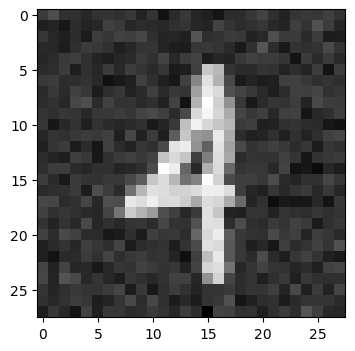

In [36]:
# plot the first image
plt.figure(figsize=(4,4))
plt.imshow(MNIST_train_noisy[0].reshape(28,28), cmap='gray');

In [37]:
# reshape the data
train_noisy = MNIST_train_noisy.reshape(-1, 28*28)
test_noisy = MNIST_test_noisy.reshape(-1, 28*28)

# reshape the original NMIST data sets
train_original = MNIST_train[:,1:].reshape(-1, 28*28)
test_original = MNIST_test[:, 1:].reshape(-1, 28*28)

In [38]:
# define a function to normalize the data
def normalize(X, mu=None,std=None, return_stats=False, revert=False):
    if revert:
        return X*std+mu
    else:
        X = X/255.
        if mu is not None and std is not None:
            Xbar = ((X-mu)/std)
        else:
            mu = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            std_filled = std.copy()
            std_filled[std==0] = 1.
            Xbar = ((X-mu)/std_filled)
        if return_stats:
            return mu, std_filled
        else:
            return Xbar


standardization

In [39]:
mu_pca,std_pca = normalize(train_noisy, return_stats=True)
train_noisy_pca = normalize(train_noisy)
test_noisy_pca = normalize(test_noisy, mu_pca, std_pca)

mu_original, std_original = normalize(train_original, return_stats=True)
train_original_pca = normalize(train_original)
test_original_pca = normalize(test_original, mu=mu_original, std=std_original, revert=False)

In [40]:
print("The shapes of the reshaped training noisy data set is: ", train_noisy_pca.shape)
print("The shape of the reshaped and training original data set is: ", train_original_pca.shape)

The shapes of the reshaped training noisy data set is:  (6000, 784)
The shape of the reshaped and training original data set is:  (6000, 784)


#### 1.2.1 PCA decomposition and show the variance explained as well as the first 10 pc

In [41]:
# perform PCA (from coding books)
def pca_function(X, m):
    """
    Return the X_pca matrix, the pcs, and corresponding eigen values.
    X: data set containing images.
    m: number of cpa.
    """
    # covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)
    
    if m < len(X[0]):
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, m, which="LM", return_eigenvectors=True)
    else: 
        eigenvalues, eigenvectors =  scipy.linalg.eigh(C) 

    # sorting and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    # v[:, i] is the ith e.vec, corresponding the ith e.value
    eigenvectors = eigenvectors[:,sorted_index]

    X_pca = X.dot(eigenvectors)
    return X_pca, eigenvectors, eigenvalues

In [42]:
m = 784  # the row number of the data
X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_pca, m)
var_explained = [evalue/sum(eigenvalues) for evalue in eigenvalues]

# varaicne of pc as m increases
# for multiple pc, the variance explained is the sum of variance over total variance
m_var_explained = np.cumsum(var_explained)

The first value of m when the variance explained is 0.7 is: 212
The first value of m when the variance explained is 0.8 is: 297
The first value of m when the variance explained is 0.9 is: 407


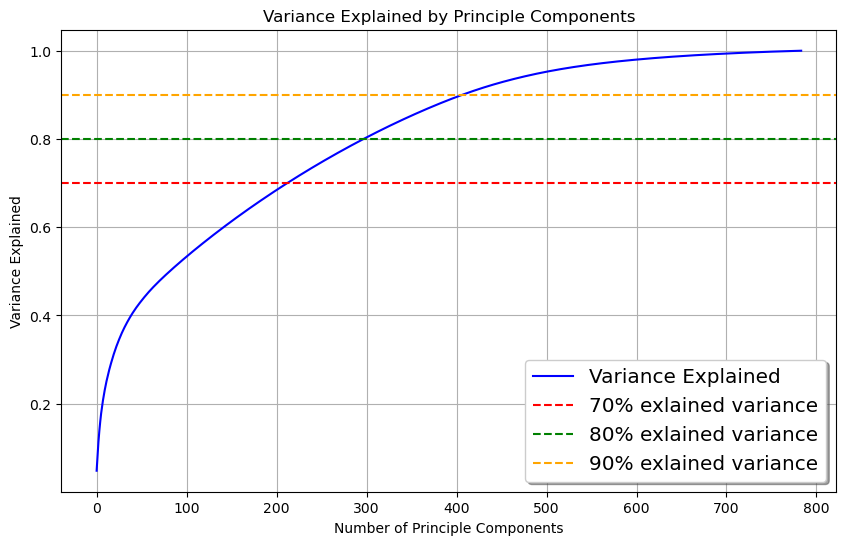

In [43]:
# plot the variance explained against m
plt.figure(figsize=(10,6))
plt.plot(m_var_explained, color='blue', label='Variance Explained')
plt.xlabel('Number of Principle Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principle Components')

# plot horizontal lines at which the value of variane explained reached 0.7, 0.8 and 0.9
plt.axhline(y=0.7, color='red', linestyle='--', label='70% exlained variance')
plt.axhline(y=0.8, color='green', linestyle='--', label='80% exlained variance')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% exlained variance')

# print the first value of m when the variance explained is 0.7, 0.8 and 0.9
print("The first value of m when the variance explained is 0.7 is:", np.where(m_var_explained>0.7)[0][0])
print("The first value of m when the variance explained is 0.8 is:", np.where(m_var_explained>0.8)[0][0])
print("The first value of m when the variance explained is 0.9 is:", np.where(m_var_explained>0.9)[0][0])
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.grid()
plt.show()


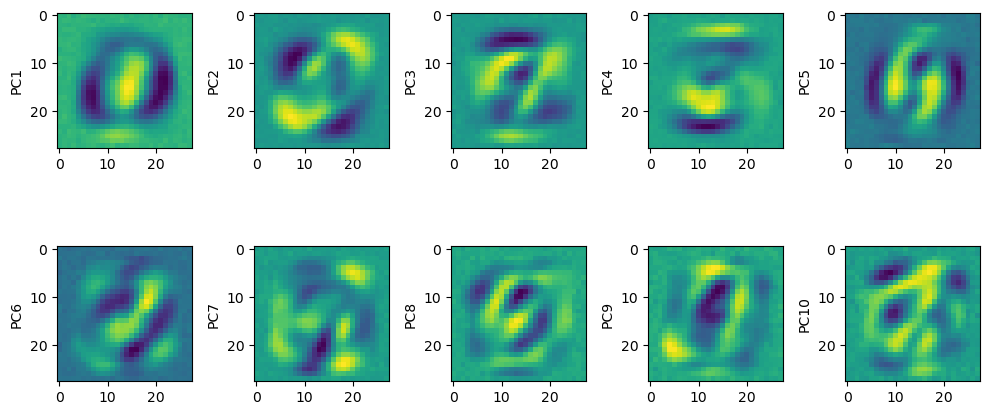

In [44]:
# visualize the first 10 principle components
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(ax.reshape(-1)):
    ax.imshow(eigenvectors[:, i].reshape(28, 28))
    ax.set_ylabel(f"PC{i+1}")

plt.tight_layout();

#### 1.2.2 NMF decomposition and comparison between components with PCA's

In [45]:
train_noisy_nmf = (MNIST_train_noisy.reshape(-1, 28 * 28)) / 255.
test_noisy_nmf = (MNIST_test_noisy.reshape(-1, 28 * 28)) / 255.

# max_min normalization
def normalize_nmf(X, min=None, max=None, return_stats = False, revert=False):
    if revert:
        return X*(max-min)+min
    if return_stats:
        return X.min(), X.max()
    else:
        X_norm = (X - X.min()) / (X.max() - X.min())
        return X_norm

In [46]:
# normalization
train_noisy_nmf = normalize_nmf(train_noisy_nmf)
min_nmf, max_nmf = normalize_nmf(test_noisy_nmf, return_stats=True)

In [47]:
# define chi2 cost, same as the notebook
def cost(X, W, H):
    """Return the chi2 cost of the NMF decomposition."""
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) ## <-- EDIT THIS LINE
    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])

    return chi2

In [48]:
# Implement NMF
# construct placeholder matrices
np.random.seed(0)
m = 10
# m x k components matrix, usually interpreted as the coefficients
W = np.random.rand(train_noisy_nmf.shape[0], m)
# k x n matrix interpreted as the basis set(e.g. pixels)
H = np.random.rand(m, train_noisy_nmf.shape[1])

chi2 = []
n_iters = 200  # the number of iterations
eps = 1e-5  # check for convergence

# loop to find chi2 error against iterations  (about 12.5 mins on microsoft)
for i in range(n_iters):
    # update first on H
    H = H * ((W.T.dot(train_noisy_nmf)) / (W.T.dot(W.dot(H)))) ## <-- EDIT THIS LINE
    # the update on W
    W = W * ((train_noisy_nmf.dot(H.T)) / (W.dot(H.dot(H.T)))) ## <-- EDIT THIS LINE
    # compute the chi2 and append to list
    chi2.append(cost(train_noisy_nmf, W, H))

# check for convergence
for i in range(1, len(chi2)):
    if abs(chi2[i-1] - chi2[i]) < eps:
        print(f"Converged at iteration {i} and the difference is {chi2[i-1] - chi2[i]}")
        break


Converged at iteration 82 and the difference is 9.69217069603321e-06


In [49]:
print("The loss for NMF at m=100: ", chi2[99])

The loss for NMF at m=100:  0.007368975662134399


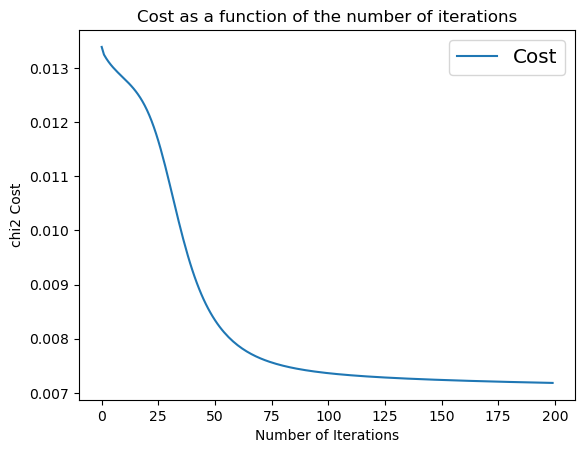

In [50]:
# plot the cost as a function of the number of iterations
plt.plot(chi2, label="Cost")
plt.xlabel("Number of Iterations")
plt.ylabel("chi2 Cost")
plt.title("Cost as a function of the number of iterations")
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.show()

#### Convergence check item
Particularly, `epsilon` is added to print the first iteration where the current is of the last ieration is less than eps difference than the last iteration. If the number is far from the chosen number of `n_iter` and that the cost is monotonically decreasing, we have reasons to believe that the number of iterations chosen is sufficient for converge. As the output and the plot shows, the fisrt iteration that meets the criterion is 82 and the cost curve is decreasing. Therefore, `n_iter=200` is a suitable choice to make sure that the cost converges.

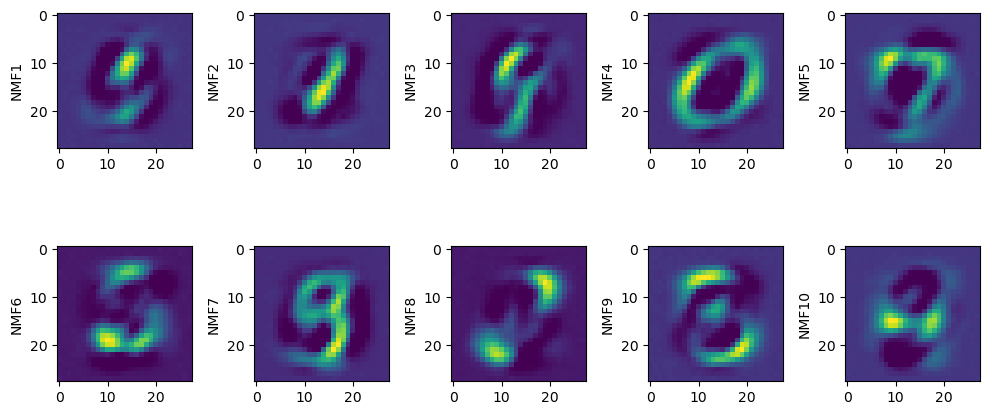

In [51]:
# visualize the m=10  components of NMF
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(ax.reshape(-1)):
    ax.imshow(H[i].reshape(28, 28))  # H[i] here represents the i-th positive eigenvector
    ax.set_ylabel(f"NMF{i+1}")

plt.tight_layout();

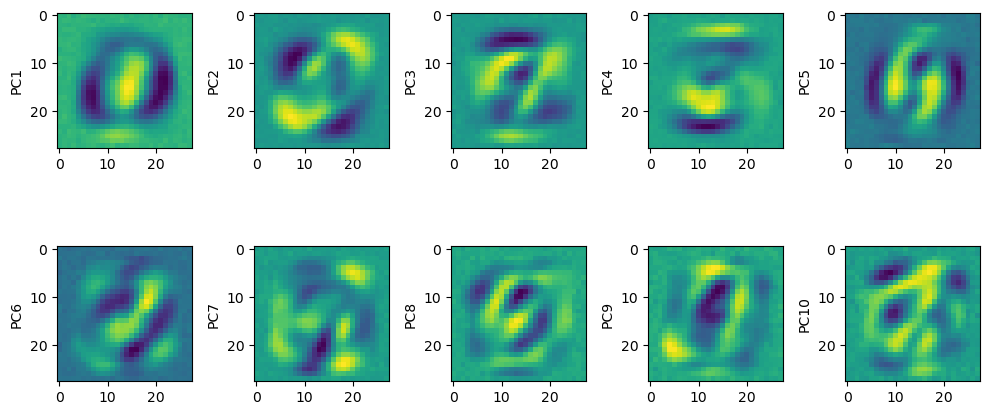

In [52]:
# visualize the first 10 principle components of PCA
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(ax.reshape(-1)):
    ax.imshow(eigenvectors[:, i].reshape(28, 28))
    ax.set_ylabel(f"PC{i+1}")

plt.tight_layout();

# Explanation:

The components of PCA and NMF are so different. This arises from their different natures of the way of decomposition.

- PCA:

The components of PCA are called 'eigenfaces', as each principle component of PCA is a modified version of the images. When combining together linearly, a lot of cancellations will be involved.

- NMF:

The components of NMF have a direct visual meaning: it contains local and sparse features of the images.

In all, each `imshow` shown for PCA components is a global representation of an image, but for NMF, each `imshow` is a partial and sparse representation of the image.

(references: https://www.nature.com/articles/44565)

#### 1.2.3 Reconstruct images and compare results.

In [53]:
# define a function to compute the mse score
def mse_score(X_either, X_reconstructed):
    """Return the mean square error between the reconstructed and corrupted or corrupted images."""
    return np.mean(np.square(X_either - X_reconstructed))

In [54]:
# train on PCA
m = 100
X_pca, train_eigenvectors, train_eigenvalues = pca_function(train_noisy_pca, m)

# the reconstructed images by pca
X_reconstructed_pca = test_noisy_pca @ train_eigenvectors @ train_eigenvectors.T  # formula from notes

# train on NMF
# construct placeholder matrices
np.random.seed(0)
W = np.random.rand(train_noisy_nmf.shape[0], m)
H = np.random.rand(m, train_noisy_nmf.shape[1])

chi2 = []
n_iters = 200  # the number of iterations

# loop over  (about 20 mins on microsoft)
for i in range(n_iters):
    # update first on H
    H = H * ((W.T.dot(train_noisy_nmf)) / (W.T.dot(W.dot(H)))) 
    W = W * ((train_noisy_nmf.dot(H.T)) / (W.dot(H.dot(H.T))))
    chi2.append(cost(train_noisy_nmf, W, H))

# reconstructed images by NMF (formula derived from notes: rows of H are analogue to principle components in PCA)
X_reconstructed_nmf = test_noisy_nmf @ H.T @ H

revert the images back to its original scale

In [55]:
X_reconstructed_pca_revert = normalize(X_reconstructed_pca,mu_pca,std_pca,revert=True)
X_reconstructed_nmf_revert = normalize_nmf(X_reconstructed_nmf,min_nmf,max_nmf,revert=True)

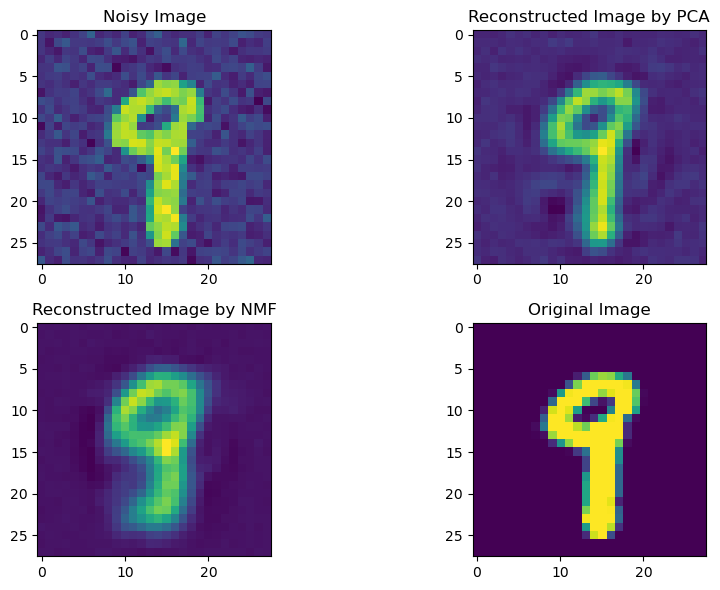

In [56]:
np.random.seed(0)
# randomly choose an image from the noisy test data set
random_image = np.random.randint(0, test_noisy_pca.shape[0])

# plot the noisy, the reconsrtucted and the original image in a row
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.imshow(test_noisy[random_image].reshape(28, 28))
plt.title("Noisy Image")
# plot the reconstructed image by PCA
plt.subplot(2, 2, 2)
plt.imshow(X_reconstructed_pca_revert[random_image].reshape(28, 28))
plt.title("Reconstructed Image by PCA")
# plot the reconstructed image by NMF
plt.subplot(2, 2, 3)
plt.imshow(X_reconstructed_nmf_revert[random_image].reshape(28, 28))
plt.title("Reconstructed Image by NMF")
# plot the original image
plt.subplot(2, 2, 4)
plt.imshow(test_original[random_image].reshape(28, 28))
plt.title("Original Image")

plt.tight_layout()
plt.show()

# Analysis:

In terms of denoising, NMF performs better, as the feature distribution is more like the original image.
But in terms of visualizing images, PCA perfroms better, as it's much clearer than the reconstructed image by NMF.

Explanation:
NMF has the following properties
- by the nature of basis and coefficient components of NMF, H and W contain a large proportion of vanishing coefficients. So both W and H(features) are sparse.
- Also, each component is a local representation of an image.
- Components of H are non-negative.


The reconstructed images are built using a linear combination of different local parts of the image(the non-negativeness of H only gives addition). This means that not all available local features are used in the linear combination. Therefore, due to the properties mentioned above, sparse addition of features is giving much less noise but also is less likely to give as many features.

On the contrary, for PCA:
- each componet of PCA is an 'eigen image', representing a modified version of the whole image.
- the components of eigenvalues and eigenvectors could be both positive and negative, meaning that the directions of variance of features can vary vastly.

The reconstructed images are built on a linear combination, not only with different eigen images, but also both additions and subtractions are allowed. The use of the whole image(rather than sparse and local features) in reconstruction and the complexities of additions and subtractions involved mean that the recontructed image will combine more features as well as noise, thus giving an better-visualized but more noisy image. 

(ref again from 1.2.2: https://www.nature.com/articles/44565)

#### 1.2.4 MSE between denoised data and test_original and test_noisy data

In [57]:
# define a function to compute the mse score
def mse_score(X_either, X_reconstructed):
    """Return the mean square error between the reconstructed and corrupted or corrupted images."""
    return np.mean(np.square(X_either - X_reconstructed))

In [58]:
np.random.seed(10)
m_range = np.arange(5, 601, 5)  # pc values
random_image = np.random.randint(0, test_noisy_pca.shape[0])

with_uncorrupted_mse_score_lis = []
with_corrupted_mse_score_lis = []
pca_examples_holder = []

for m in m_range:
    _, train_eigenvectors, _ = pca_function(train_noisy_pca, m)
    X_reconstructed_pca = test_noisy_pca @ train_eigenvectors @ train_eigenvectors.T
    X_reconstructed_pca_revert = normalize(X_reconstructed_pca, mu_pca, std_pca, revert=True)
    
    with_uncorrupted_mse_score = mse_score(test_original/255, X_reconstructed_pca_revert)
    with_corrupted_mse_score = mse_score(test_noisy/255, X_reconstructed_pca_revert)

    with_uncorrupted_mse_score_lis.append(with_uncorrupted_mse_score)
    with_corrupted_mse_score_lis.append(with_corrupted_mse_score)

    if m in [10, 40, 100, 200, 400, 600]:
        X_reconstructed_pca_revert = normalize(X_reconstructed_pca,mu_pca,std_pca,revert=True)
        pca_examples_holder.append(X_reconstructed_pca_revert[random_image])


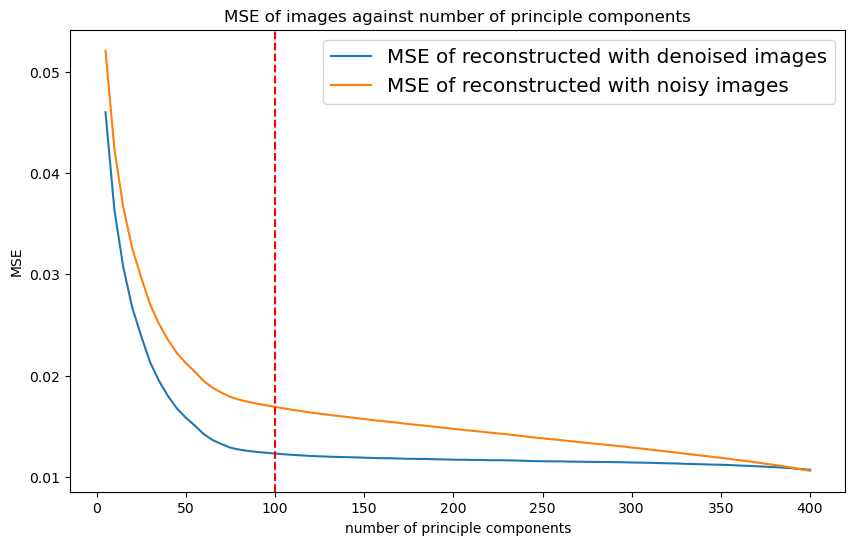

In [59]:
# plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(m_range[0:80] , with_uncorrupted_mse_score_lis[0:80], label="MSE of reconstructed with denoised images")
plt.plot(m_range[0:80], with_corrupted_mse_score_lis[0:80], label="MSE of reconstructed with noisy images")
plt.axvline(100, color="red", linestyle='--')
plt.xlabel('number of principle components')
plt.ylabel('MSE')
plt.title('MSE of images against number of principle components')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.show()

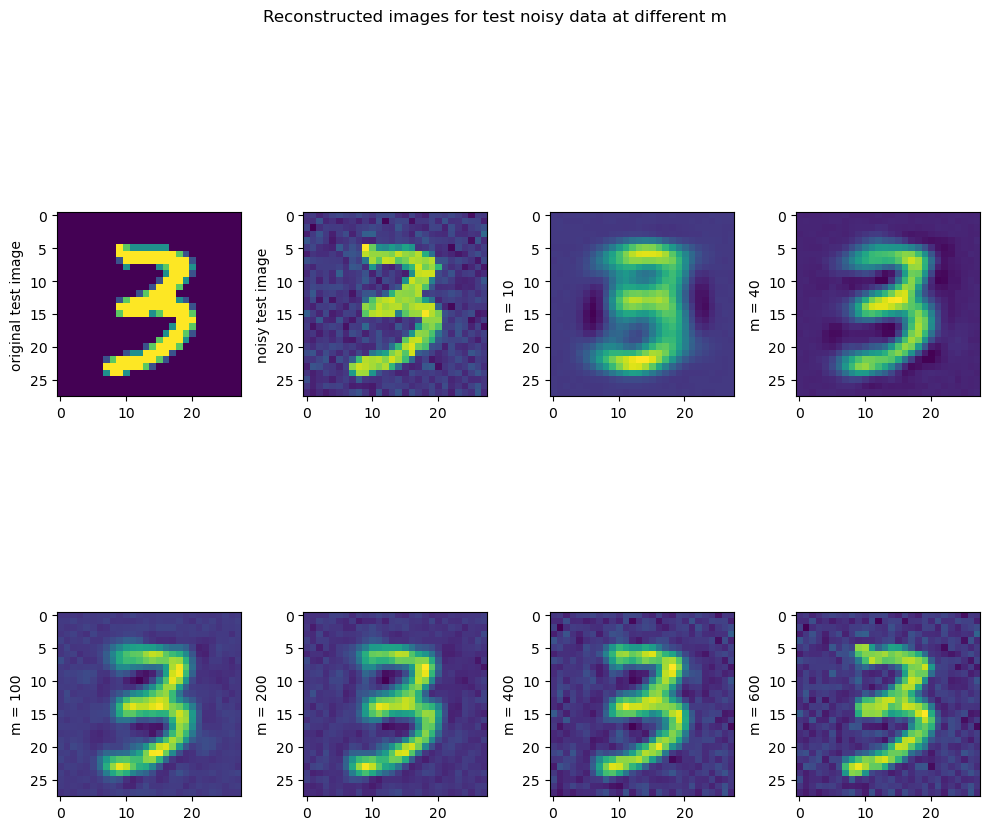

In [60]:
# plot the example figure
plt.figure(figsize=(10, 10))
plt.subplot(2,4,1)
plt.imshow(test_original[random_image].reshape(28,28))
plt.ylabel('original test image')

plt.subplot(2,4,2)
plt.imshow(test_noisy[random_image].reshape(28,28))
plt.ylabel('noisy test image')

plt.subplot(2,4,3)
plt.imshow(pca_examples_holder[0].reshape(28,28))
plt.ylabel('m = 10')

plt.subplot(2,4,4)
plt.imshow(pca_examples_holder[1].reshape(28,28))
plt.ylabel('m = 40')

plt.subplot(2,4,5)
plt.imshow(pca_examples_holder[2].reshape(28,28))
plt.ylabel('m = 100')

plt.subplot(2,4,6)
plt.imshow(pca_examples_holder[3].reshape(28,28))
plt.ylabel('m = 200')

plt.subplot(2,4,7)
plt.imshow(pca_examples_holder[4].reshape(28,28))
plt.ylabel('m = 400')

plt.subplot(2,4,8)
plt.imshow(pca_examples_holder[5].reshape(28,28))
plt.ylabel('m = 600')

plt.suptitle("Reconstructed images for test noisy data at different m")
plt.tight_layout()
plt.show()

# Explanation:

- The MSE decreases fast at about first `m=100` components (dotted-red line). This is because, PCA factorizes out principle components in decending order and eigenvectors(which statistically represent variance explained) corresponding to greater eigenvalues bear with more represented features in the reconstructed images. Therefore MSE decreases rapidly at start.

- After `m=100`, the MSE with test data still decreases while MSE with original data remains almost stable. This means that the added principle components help little in denoising the noisy images and thus adding more components is pointless in decreasing MSE. But for test noisy data, the added components are adding more information (but it's just noise) about images to the basis of components and give a decreasing MSE.

The trend above(orange) can be corresponded in the reconstructed test noisy images plotted for different $m$s:

- Images become clear rapidly from `m=10` to `m=40` and `m=100`.

- Images change little, either the background or the number part, from `m=100` to `m=400`, because adding components are just adding more noise.

In all, none of the reconstructed images resemble the original image for the background part, which means that the PCA does not perform well in denoising data. But the reconstructed images are closer to the noisy data, meaning that PCA components fit well to unseen noisy data and is good at visualizing noisy images. 

As `m` further increases, the MSE with reconstructed images and test noisy images are expected to further decrease (which is verified below). This trend can also be seen from the last plot.

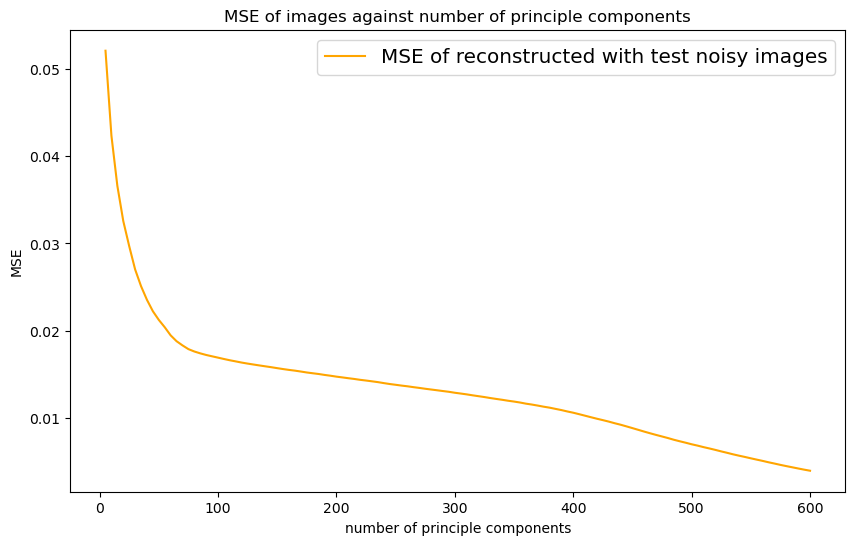

In [61]:
# verify the MSE after 400
plt.figure(figsize=(10, 6))
plt.plot(m_range, with_corrupted_mse_score_lis, color='orange', label="MSE of reconstructed with test noisy images")
plt.xlabel('number of principle components')
plt.ylabel('MSE')
plt.title('MSE of images against number of principle components')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.show()

--------------------------------------------------------------------------------------------------------------------------

#### 1.3 Gaussian Mixture Models (20 marks)

In this section, digits' images are reconstructed based on 5 principle components and then are being clustered by GMM models, with 10, 5 and 8 hidden components respectively.

For each of 3 models:
- the best-fitting cluster indexes are computed, by involving log likelihoods. 
- to measure the uncertainty of clustering, space spanned by the first 2 principle components are plotted as well as for each digit class.

Intuitively, number of hidden components should be at least the number of digits, but for similar types of images, especially those only built on 5 pc, GMM with less hidden components are likely to perform better. The discussion will be included in the section.

Note that in EM algorithm, a convergence check is set up after each EM step to stop the next iteration if the previous `mu` and `sigma` are close to avoid overflow.

#### 1.3.1 GMM on probablistic clustering with 10 hidden components

In [62]:
class GMModel:
    """Define Gaussian Mixture Model class"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim  # number of k

        # initial weights/ P(Ci=j)/ prior
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim)  # <- fill the array of shape with values fill_value

        # initial weights/ P(Xi/Ci=j)/ likelihood
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n, m = X.shape 
        # as a generator of self.mu
        random_row = np.random.randint(low=0, high=n, size=self.dim)  # <- could be repeated

        # initial value of mean of k Gaussians and sigmas
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 


In [63]:
def cluster_probabilities(gmm, X):
    """Predicts cluster probability for each data point."""
    
    n, m = X.shape
    # l_ij = p(x_i|theta_j)
    likelihood = np.zeros((n, gmm.dim))

    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution =  multivariate_normal(mean=gmm.mu[i], cov=gmm.sigma[i]) # <- from scipy
        likelihood[:,i] = distribution.pdf(X)

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis] # axis=1: col sum: across diff k
        weights = numerator / denominator

    return weights

In [64]:
def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm, X)
    return  np.argmax(weights, axis=1)

In [65]:
# implement EM algorithm
def fitStep(gmm, X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant: down in "/total_weight"
    # M-Step: update mu and sigma holding pi and weights constant
    weights = cluster_probabilities(gmm,X)
    gmm.phi = weights.mean(axis=0)  # prior
        
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight
        # bias=True: normalize by num(observations)
        gmm.sigma[i] =  np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)

In [66]:
# train the model with EM. But with a convergence check
def train_gmm(X, n_components, n_iters=1000, eps=1e-8):
    gmm = GMModel(X,n_components)
    prev_mu = gmm.mu.copy()
    prev_std = gmm.sigma.copy()
    for i in range(n_iters):
        fitStep(gmm,X)
        if np.allclose(prev_mu, gmm.mu) and np.allclose(prev_std, gmm.sigma):
            print(f"Converged at iteration {i}!")
            break
        prev_mu = gmm.mu.copy()
        prev_std = gmm.sigma.copy()
    return gmm

Converged at iteration 378!


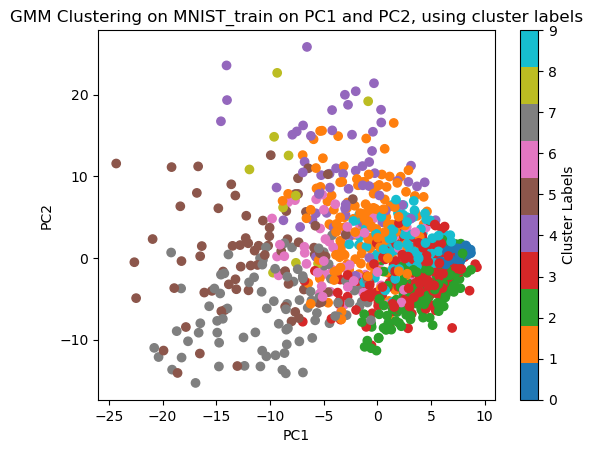

In [67]:
m = 5

np.random.seed(2)
X_pca_131, eigenvectors_131, eigenvalues_131 = pca_function(train_original_pca[0:1000], m)  
gmm = GMModel(X_pca_131, 10)
gmm = train_gmm(X_pca_131, n_components=10, n_iters=1000, eps=1e-8)

# hard clustering
cluster_labels = predict(gmm, X_pca_131)
# visualize the space spanned
plt.scatter(X_pca_131[:, 0], X_pca_131[:, 1], c=cluster_labels, cmap="tab10")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Labels')
plt.title('GMM Clustering on MNIST_train on PC1 and PC2, using cluster labels')
plt.show()

#### 1.3.2 Find the best-fitting cluster index and discuss the result

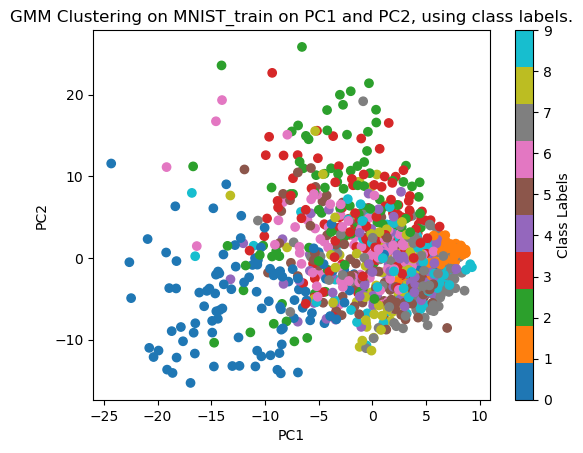

In [68]:
class_labels = MNIST_train[:1000, 0]

# visualize the space spanned
plt.scatter(X_pca_131[:, 0], X_pca_131[:, 1], c=class_labels, cmap="tab10")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Class Labels')
plt.title('GMM Clustering on MNIST_train on PC1 and PC2, using class labels.')
plt.show()

In [69]:
def log_probs(gmm, X):
    """
    Return a matrix of shape (n_sample, n_components), 
        each elemt is the log probability of X_i belonging to the kth mixture component.
    """

    n,m = X.shape 
    log_prob = np.zeros((n, gmm.dim))
    
    for i in range(gmm.dim):
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        # log probability for each x at component i
        log_prob[:,i]=distribution.logpdf(X)

    return log_prob

In [70]:
def label_cluster_mapping(gmm, X, class_labels):
    """
    Return a map of class labels to best_fitting cluster index.
    Args:
        gmm: Gaussian mixture model.
        X: data set
        class_labels: given class labels.
    """

    all_log_likelihoods = log_probs(gmm, X)

    class_log_likelihood = []
    for i in np.unique(class_labels):
        label_indicator = (class_labels == i)
        class_log_likelihood.append(np.sum(all_log_likelihoods[label_indicator],axis = 0))
    
    cluster_labels = np.argmax(class_log_likelihood, axis=1)

    return {class_label: cluster_label for class_label, cluster_label in zip(np.unique(class_labels), cluster_labels)}

In [71]:
# print the map
class_cluster_map = label_cluster_mapping(gmm, X_pca_131, class_labels)
print("The label cluster mapping is: ", class_cluster_map)

The label cluster mapping is:  {0: 5, 1: 0, 2: 4, 3: 1, 4: 3, 5: 1, 6: 6, 7: 3, 8: 1, 9: 3}


# Analysis:

The keys of the mapping dictionary are the class label and the values of the mapping are best-fitting index of normal distributions:

$\cdot$ One interesting thing to notice is that digit 3, 5 and 8 are both mapped to label 1. In reality of hand-writting, these 2 digits do look alike for roughly their shapes.

$\cdot$ In addition, digit 4, 7 and 9 are clustered to label 3.

- Reason: This GMM model assumes each digit is driven by a corresponding latent distribution. But we only use 5 principle components to represent the images, and from section 1.2, we know that images reconstructed by `m=5` are clear in the background but blurred on the lighter part -- where the digits manifest. This tells the features captured are insufficient to represent distinct features of images of digits. And digits with similar rough shapes are more likely to be clustered as the identical digit.

Analysis wrt the plot above is included in the explanation in 1.3.3

#### 1.3.3 Uncertainty of clusteirng visualized on classes

In [72]:
# log probs matrix: containing all the log-probs of data point, X_i to the kth mixture components
log_cluster_prob = log_probs(gmm, X_pca_131)
print(log_cluster_prob)

[[ -16.97570347  -18.7475566   -14.76573705 ...  -19.31242479
  -282.41979186  -11.23842018]
 [-114.66542145  -15.01411727  -19.51109961 ...  -32.36062497
  -200.37780552  -44.10846414]
 [-101.16633094  -15.31546101  -11.40404744 ...  -33.75332819
  -170.75535242  -57.92117636]
 ...
 [-148.20503636  -13.40809482  -17.53956278 ...  -26.11280143
  -132.32450628  -47.96001604]
 [-698.52436219  -12.81893972  -52.78271987 ...  -30.4427656
  -110.48773354  -63.4990667 ]
 [-226.9374572   -19.090202    -15.9754111  ...  -12.50942501
  -110.07120331  -34.46886479]]


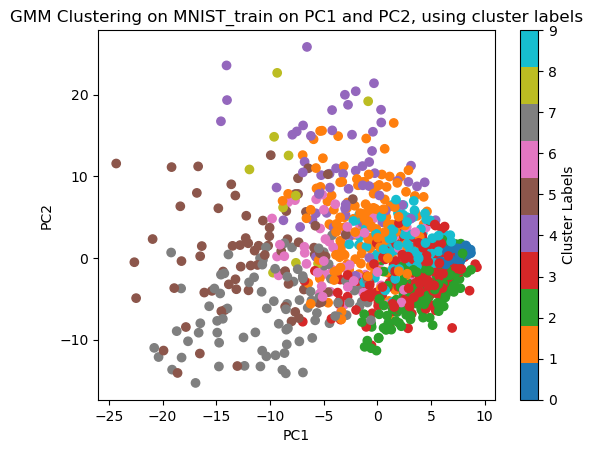

In [73]:
# replot from 1.3.2
# visualize the space spanned
plt.scatter(X_pca_131[:, 0], X_pca_131[:, 1], c=cluster_labels, cmap="tab10")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Labels')
plt.title('GMM Clustering on MNIST_train on PC1 and PC2, using cluster labels')
plt.show()

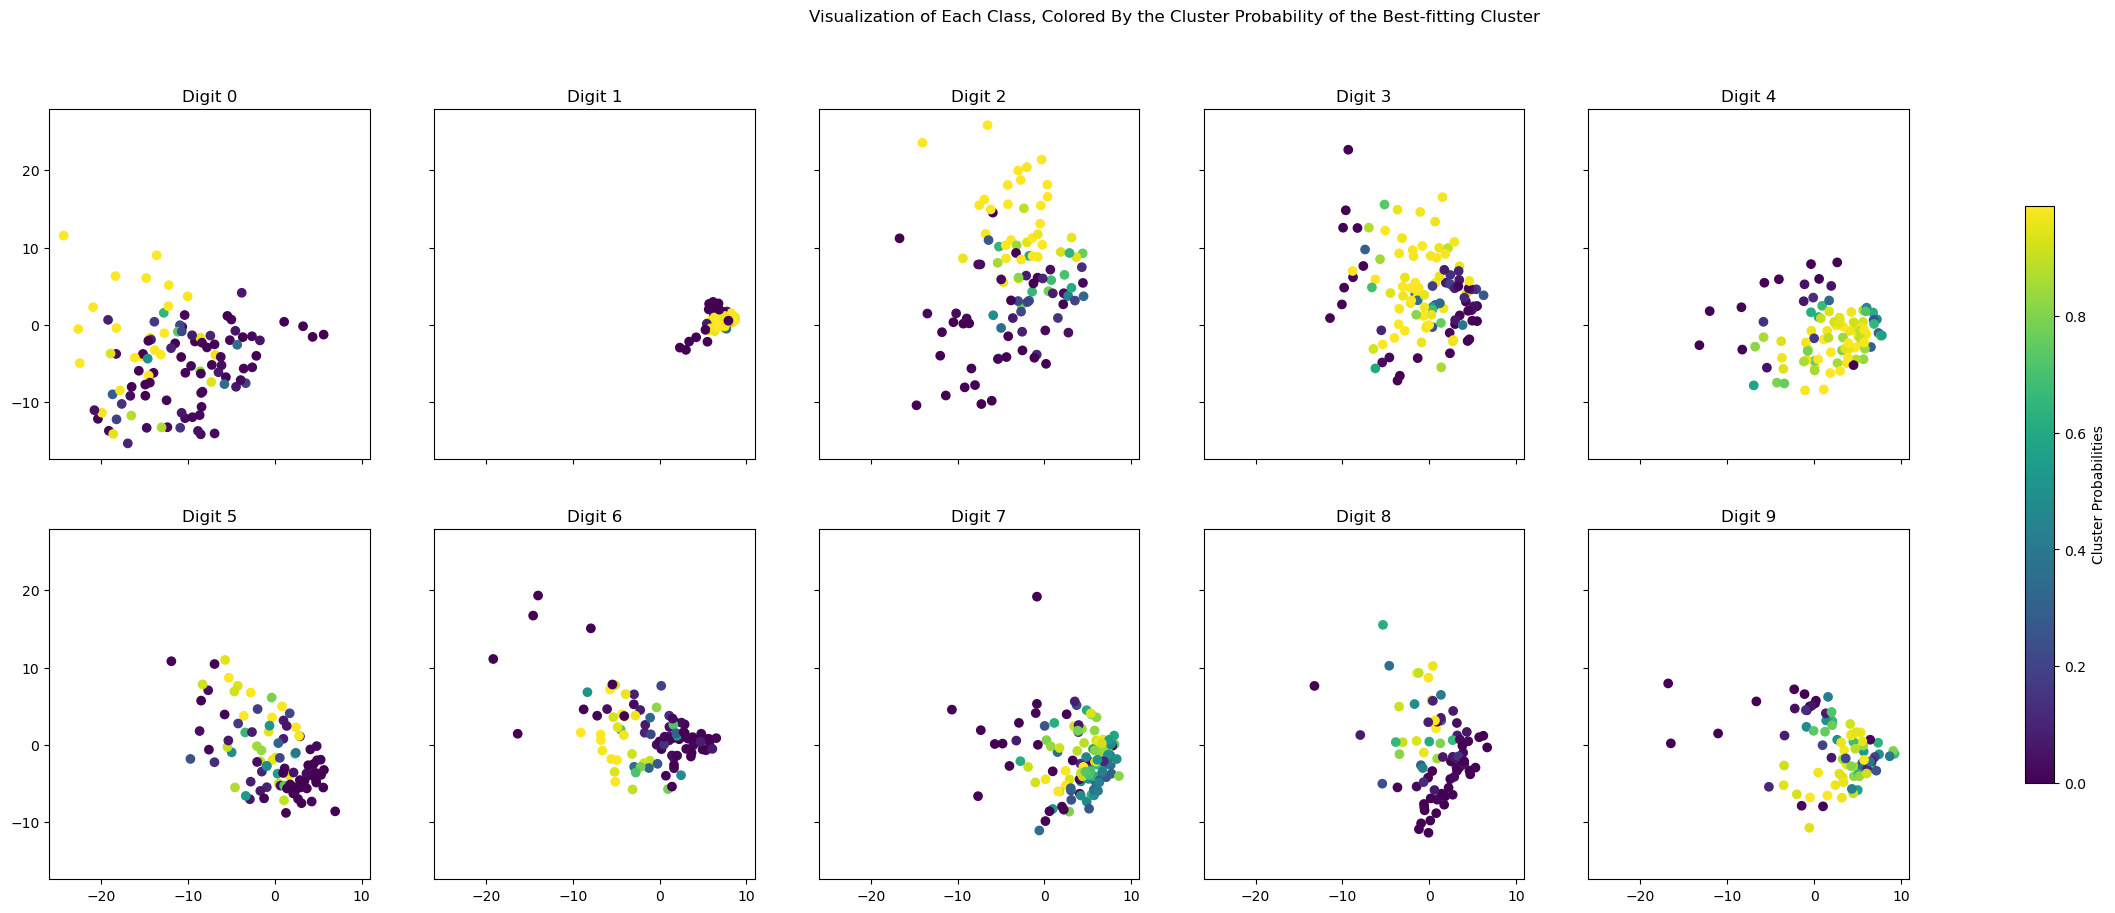

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    label_indicator = (class_labels == i)
    cluster_probs_total = cluster_probabilities(gmm, X_pca_131[label_indicator, :]) 
    cluster_probs = cluster_probs_total[:, class_cluster_map[i]]

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=cluster_probs.min(), vmax=cluster_probs.max())
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = sm.to_rgba(cluster_probs)

    ax.scatter(X_pca_131[label_indicator, 0], X_pca_131[label_indicator, 1], c=colors)
    ax.set_title('Digit {}'.format(i))
    
fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.75, label='Cluster Probabilities')
plt.suptitle("Visualization of Each Class, Colored By the Cluster Probability of the Best-fitting Cluster")
plt.show()


# Analysis:

The plot above gives the uncertainty of the class points assigned to the best-fitting cluster. The brighter the color, the more likely that the digits are assigned to the best-fitting cluster, based on 5 principle components.

To view the uncertainty: 

- First take a look on how the cluster probabilities vary within each class. If the distribution of the cluster probabilities are evenly distributed, it means more uncertainty in the clustering as such distributions makes it hard to decide the dominant digit and therefore lead to unstableness. Moreover, we want to have as many yellow dots as possible to determine the dominant digit.

By this, GMM model with 10 hidden components has a great uncertainty: Apart from digit 0, 1, 2 and 3, other digit classes either has a distribution with a wide range of values of cluster probabilities or there are many dark-color points which makes it hard to determine the dominant label.

- Second, we can take a look on how well-separated the different clusters are in the scatter plot above. If different clusters are well-separated, then it suggests the clustering is more certain and the cluster probability is low. On the other hand, if the a region of plot is densely stacked with clusters, it has smaller uncertainty ie. higher cluster probability.

From this, the clusters are highly stacked on the lower right part of the plot, giving low cluster probability to the corresponding areas of each class, eg. for the green dots in the scatter plot, it has orange, red and pink stacking on it, giving a dark color of cluster probability at the corresponding lower right part in the plot of digit 8. For clyster 5, the brown dots, it's individually and densely distributed around the area $(-25, 15)\cdot (5, 15)$. Therefore, it gives yellow dots to the corresponding region in the plot of digit 0.

#### 1.3.4 Retrain GMM with 5 nad 8 digits

In [75]:
def train_map_plots(hidden_components, n_its = 1000):
    # train
    gmm = train_gmm(X_pca_131, hidden_components)

    # map
    class_labels = MNIST_train[:1000, 0]
    label_cluster_map = label_cluster_mapping(gmm, X_pca_131, class_labels)
    print("Label-Cluster Index Map: ", label_cluster_map)

    # plot
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    # color by clusters
    cluster_labels = predict(gmm, X_pca_131)
    sc0 = ax0.scatter(X_pca_131[:, 0], X_pca_131[:, 1], c=cluster_labels, cmap="tab10")
    ax0.set_xlabel('PC1')
    ax0.set_ylabel('PC2')
    ax0.set_title(f'Coloring Cluster Labels, for {hidden_components} components')
    cbar = fig.colorbar(sc0, ax=ax0)
    cbar.ax.set_ylabel('Cluster Labels')
    # color by class labels
    sc1 = ax1.scatter(X_pca_131[:, 0], X_pca_131[:, 1], c=class_labels, cmap="tab10")
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_title(f'Coloring Class Labels, for {hidden_components} components')
    cbar = fig.colorbar(sc1, ax=ax1)
    cbar.ax.set_ylabel('Class Labels')

    plt.show()

    # plot each individual class
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        mask = (class_labels == i)
        cluster_probs_total = cluster_probabilities(gmm, X_pca_131[mask, :]) 
        cluster_probs = cluster_probs_total[:, label_cluster_map[i]]

        cmap = plt.cm.get_cmap('viridis')
        norm = plt.Normalize(vmin=cluster_probs.min(), vmax=cluster_probs.max())
        sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
        colors = sm.to_rgba(cluster_probs)

        ax.scatter(X_pca_131[mask, 0], X_pca_131[mask, 1], c=colors)
        ax.set_title('Digit {}'.format(i))

    plt.suptitle("Visualization of Each Class of Digit, Colored By the Cluster Probability of the Best-fitting Cluster Label")
    fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.75, label='Cluster Probabilities')
    plt.show()

Retrain with 5 hidden components

Converged at iteration 179!
Label-Cluster Index Map:  {0: 2, 1: 4, 2: 3, 3: 3, 4: 1, 5: 2, 6: 3, 7: 1, 8: 2, 9: 3}


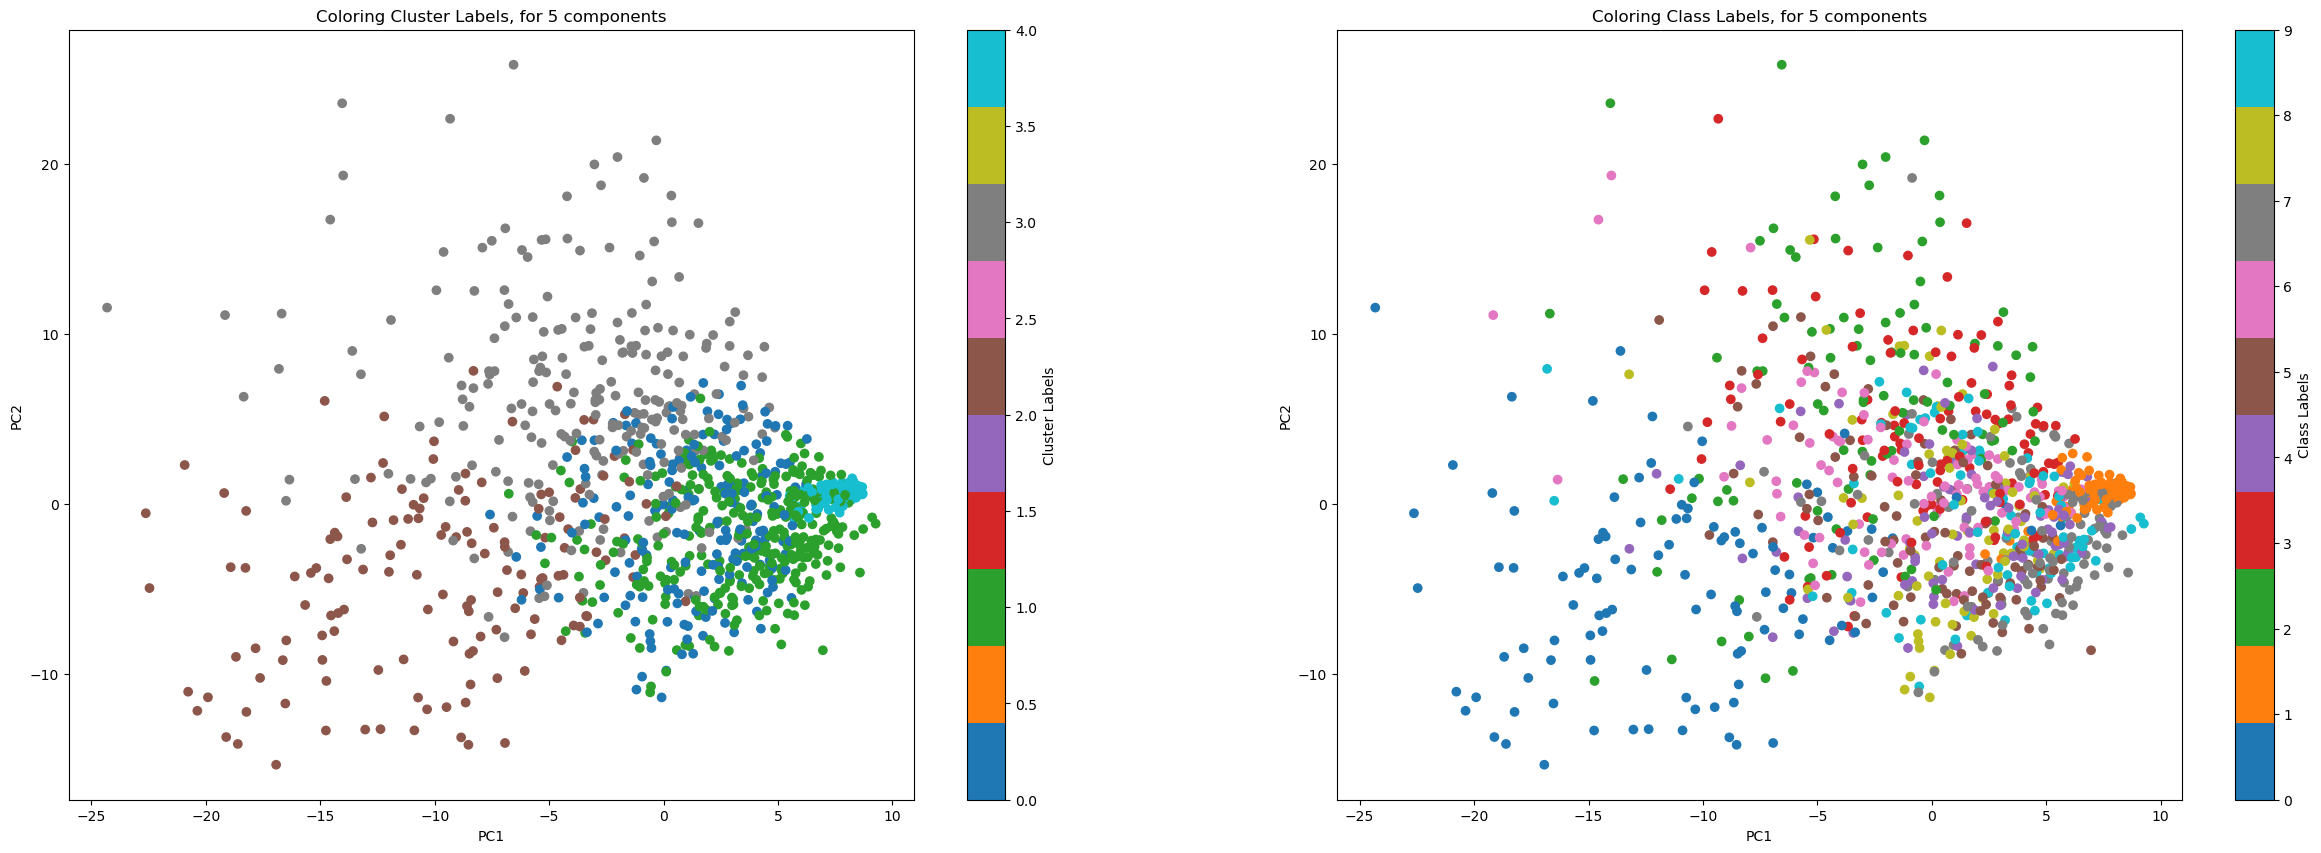

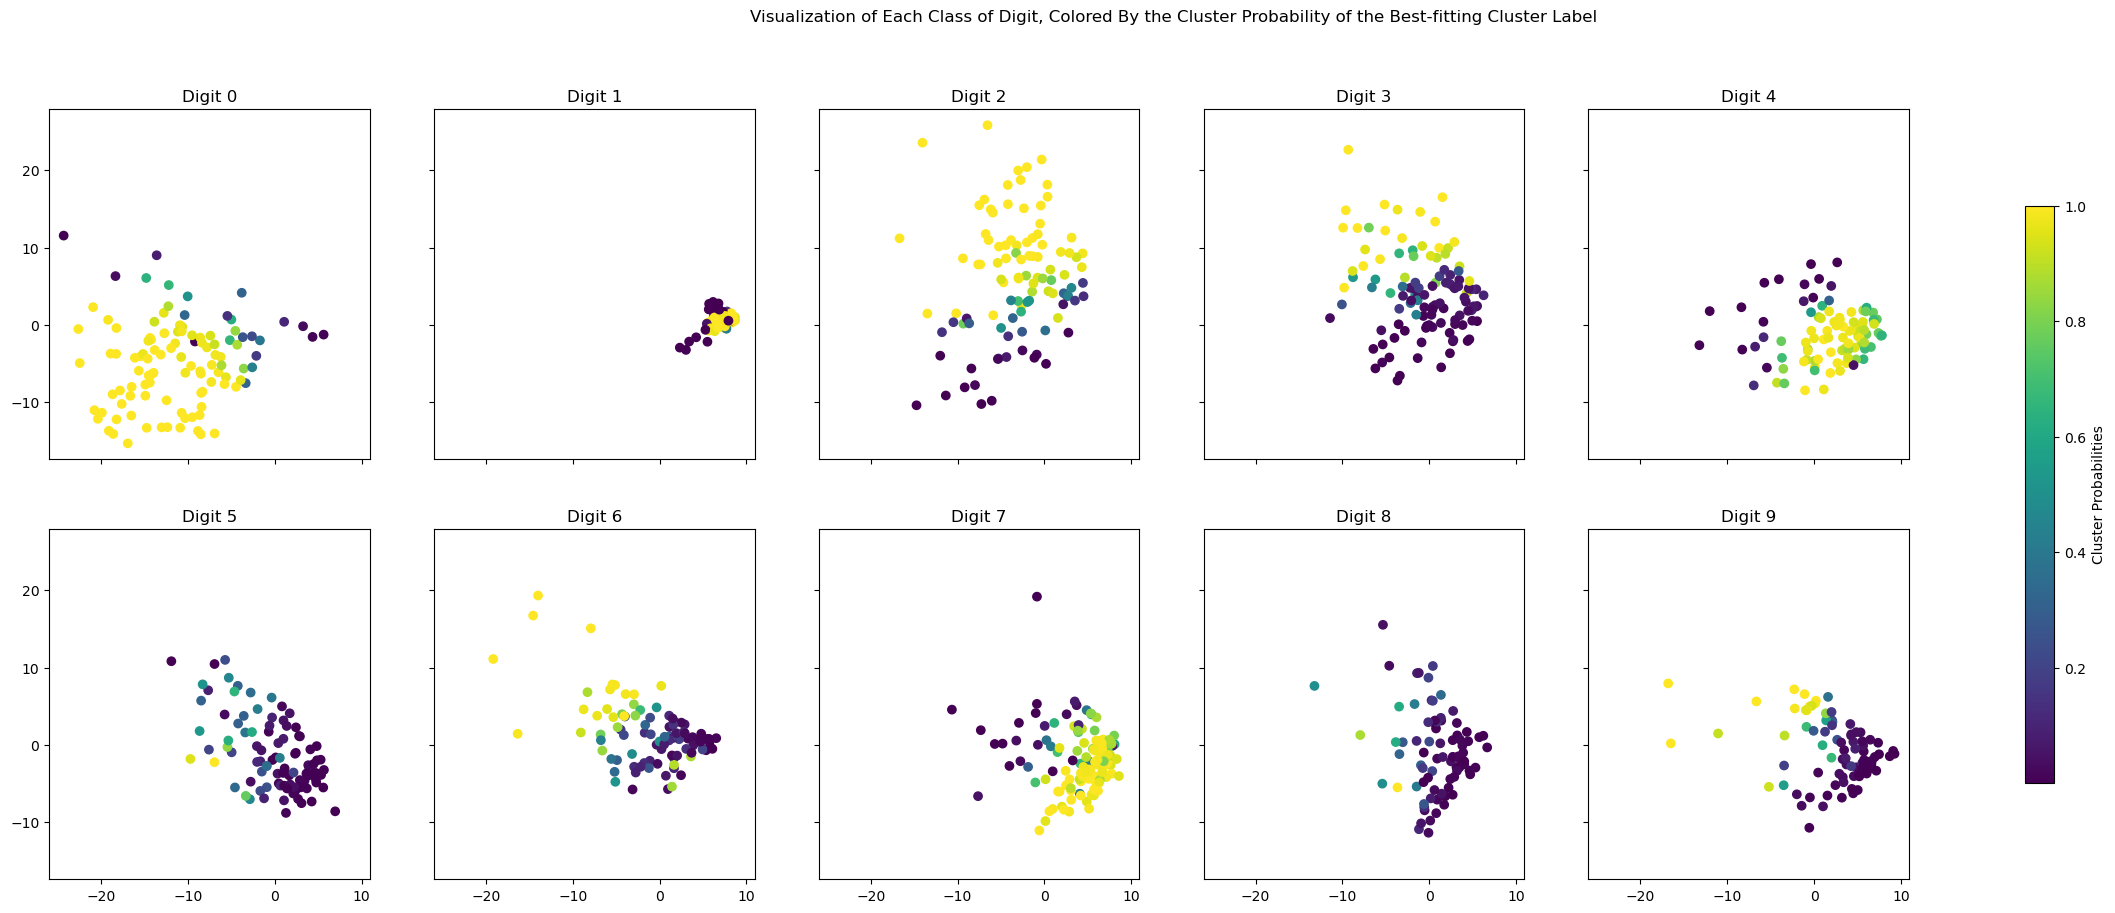

In [76]:
hidden_components = 5
train_map_plots(hidden_components, n_its = 1000)

Retrain with 8 components

Converged at iteration 305!
Label-Cluster Index Map:  {0: 5, 1: 6, 2: 3, 3: 2, 4: 3, 5: 5, 6: 3, 7: 1, 8: 7, 9: 3}


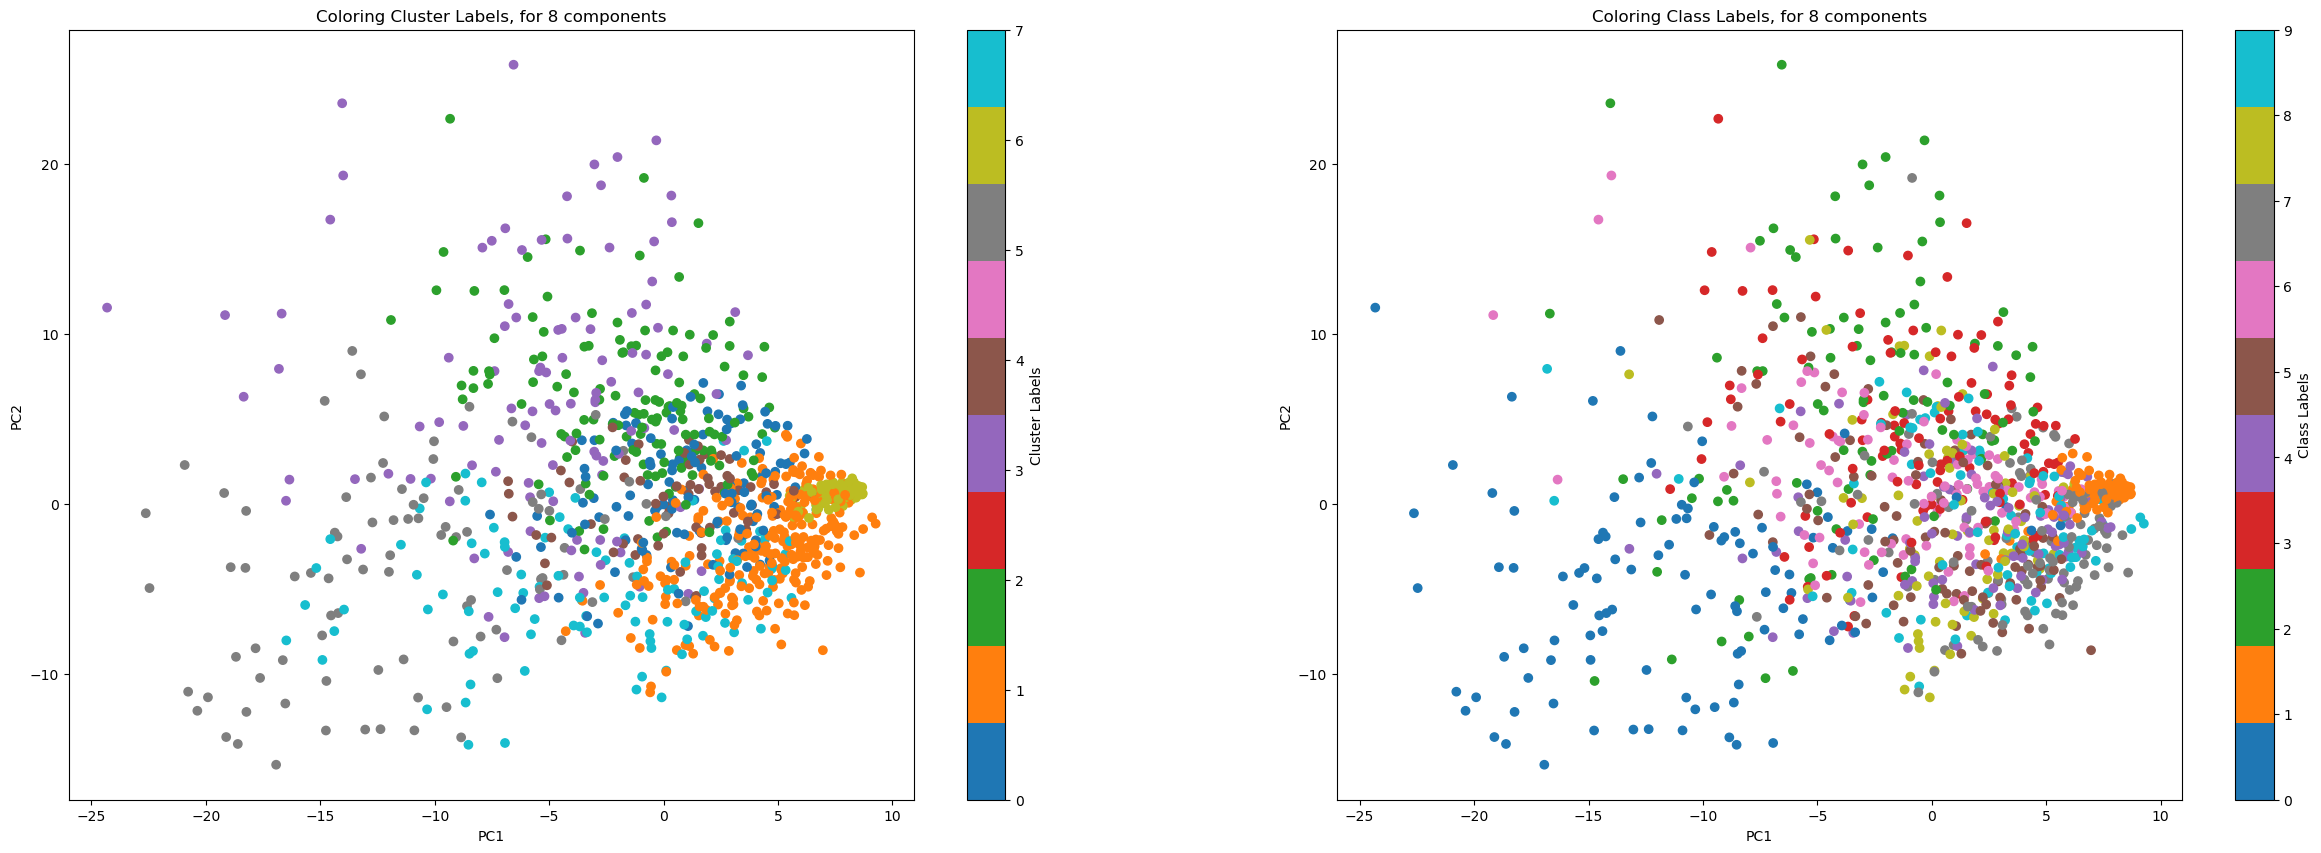

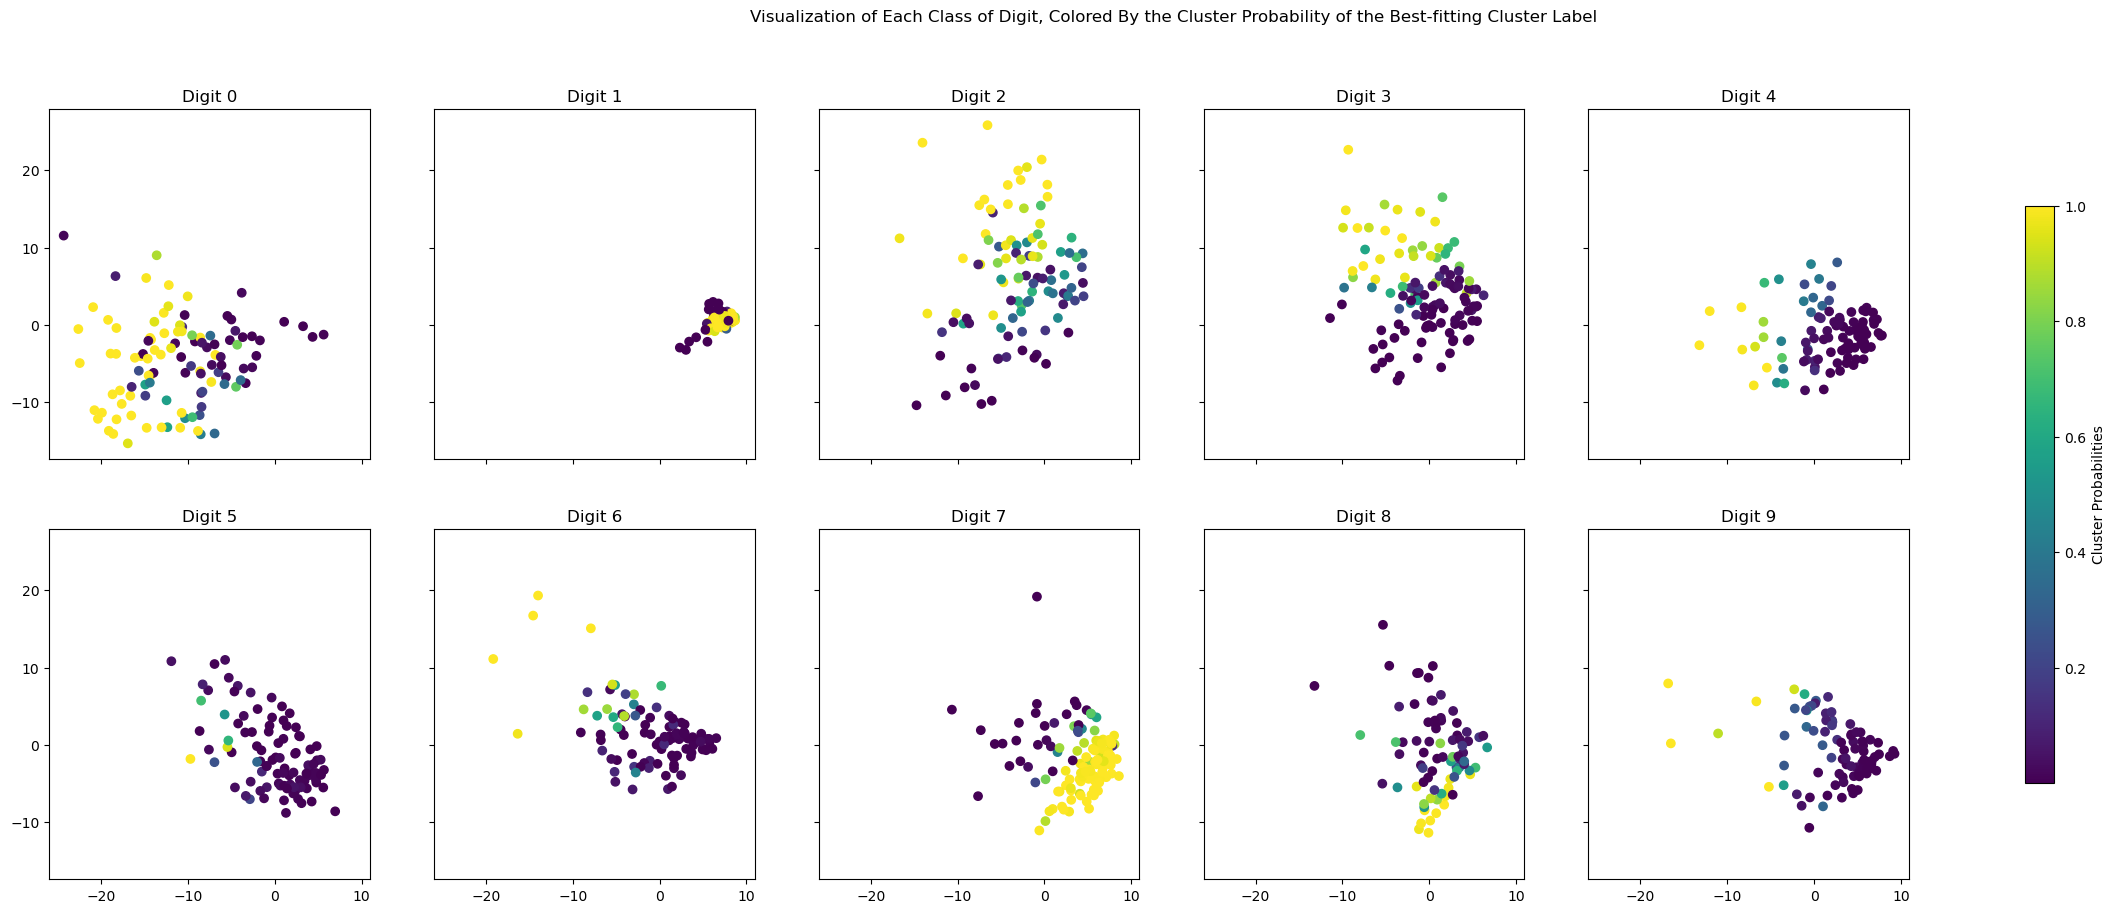

In [77]:
hidden_components = 8
train_map_plots(hidden_components, n_its = 1000)

# Analysis:

Usually, the number of hidden components should be be at least the number of classes (in this case 10), by assuming each digit follows a distinct distribution. But if elements of classes are 'similar', less hidden components could lead to a good clustering outcome. From 1.2.4, we see that the reconstructed images, even at `m=10`, are super-vague, not to mention we only used `m=5` in this section. In this case, the recontructed digit images are really blurred (also shown below) and are likely to bring highly-similar patterns and information to the clustering machine.


- Comparison for GMM with 5, 8, 10 hidden components

|| 5 | 8 | 10 
|----------|----------|----------|----------|
| digits clustered to the same distribution: | 479 to 3, 358 to 1 | 2369 to 3, 05 to 2, 47 to 1 | 2469 to 3, 0 to 55
| numerous yellow points (Y/N)| YNN, NNN | YNNN, YN, NY | NNNN, Y


- In terms of distributions of clusters in the scatter plot, it can be seen obviously that for reduced hidden components to 5, the clusters are more well-separated, showing a reduced uncertainty.

- One thing in common is that cluster probabilities are high for clusters densely overlapped. This is bacause points in highly dense areas mean samples are similar in these 2 dimensions. This will make clustering more difficult and lead to more uncertainty.

compliment to the analysis

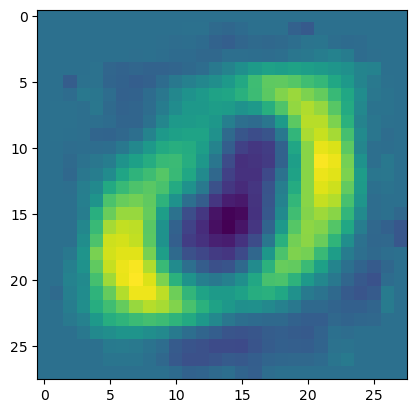

In [78]:
# to show: reconstructed images for 5 principle components is highly blurred
test_constructed = test_original_pca @ eigenvectors_131 @ eigenvectors_131.T
plt.imshow(test_constructed[0].reshape(28,28))
plt.show()

--------------------------------------------------------------------------------------------------------------------------------

### Task 2: Clustering and graph-based analysis (35 marks)

In [79]:
# import and do the data exploration
gene_data = pd.read_csv("gene_expression_data.csv", decimal=",")  # as a pandas data frame
# expressions
gene_expression = gene_data[gene_data.columns[:-1]].astype(float)
# type (labels)
gene_type = gene_data[gene_data.columns[-1]]
display(gene_data.head(5))

print("The type of the gene_data, espressions and types:", type(gene_data))
print("The type of espressions:", type(gene_expression))
print("The type of types:", type(gene_type))
print("The shape of the data is:", gene_data.shape)

,Gene 0,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,...,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Type
0,9.79608829288,0.591870870063,0.591870870063,0.0,11.4205708246,13.4537593388,4.41184651859,5.4123344238,10.7716132653,10.2256653627,...,5.97436869818,8.08651310808,12.7277503154,15.2057168981,6.43811649662,6.412576621,0.0,6.81472985199,13.6181445741,PRAD
1,10.0704698332,0.0,0.0,0.0,13.085671621,14.5318626848,10.4622977655,9.83292639746,13.5203117438,13.9680457391,...,0.0,0.0,11.1972044043,12.9939325894,10.8007462415,10.7498107801,0.0,11.445609809,0.0,LUAD
2,8.97091978401,0.0,0.452595434703,0.0,8.26311893627,9.75490753946,8.96454880885,9.94811313134,8.6937726804,8.7761105697,...,3.90715987355,5.32410132,11.4870662364,13.3805963452,6.65623606704,10.2097335917,0.0,7.7488301787,12.759975541,PRAD
3,8.52461614952,1.03941918313,0.434881719407,0.0,10.7985204031,12.2630197299,7.44069478818,8.06234301354,8.80208333007,9.23748723755,...,4.29608291884,6.95974697548,12.974638649,14.8918121772,6.03072451189,7.31564773826,0.434881719407,7.11792356209,12.3532764196,PRAD
4,8.04723845046,0.0,0.0,0.360982241369,12.2830101953,14.033758513,8.71918001723,8.83147193285,8.46207277429,8.21120206054,...,0.0,0.0,11.3372372064,13.3900614488,5.98959318494,8.35967050637,0.0,6.32754545866,0.0,BRCA


The type of the gene_data, espressions and types: <class 'pandas.core.frame.DataFrame'>
The type of espressions: <class 'pandas.core.frame.DataFrame'>
The type of types: <class 'pandas.core.series.Series'>
The shape of the data is: (800, 96)


In [80]:
# standardize the data
def standardize(X):
    """Return a standardized dataset."""
    if type(X) != np.ndarray:
        X = X.to_numpy()

    mean = np.mean(X, 0)
    std = np.std(X, 0)
    return (X - mean)/std

## 2.1 Clustering (15 marks)

In this section, k-means clustering is implemeted for the gene expressions, where k is treated as a hyperparameter to tune. The highest Calinski-Harabasz index is used as a measure to find the optimal k and consistency of the clustering is assessed by homogeneity score.

Two things to notice:
- In the initialization of labels in k-means algorithm, in order to avoid the situation where none of a sample is assigned to a certain cluster, we first randomly choose n-k samples from range 0 to k, and then add the labels with additional k labels, each of which is from a cluster. This guarantees at least one intially assigned sample for each cluster.

- In computing $a_{ck}$ in homogeneity score, we should avoid it to be 0 as logarithm will be taken on it. For this case, simply skip it ie. add zero to the total sum, which will result into a slight underestimation in the true value of the total sum, compared to the result given by sklearn.

#### 2.1.1 k-means clustering and find the optimal k

In [81]:
gene_expression = standardize(gene_expression)

In [82]:
def compute_centroids(X, k):
    """
    Return the centroid for each cluster according to assignments.
    Args:
        X: data
        k: number of clusters
    """

    if type(X) != np.ndarray:
        X = X.to_numpy()

    n_samples, n_features = X.shape
    
    # assign labels, each time with different initialization, but use a 'trick' to unsure at least 1 point in each cluster
    labels = np.random.randint(low=0, high=k, size=n_samples-k)
    labels = np.concatenate((labels, np.arange(k)))
    random.shuffle(labels)

    # initialization
    centroids = np.zeros((k, n_features))

    # compute the centroids of points with the same assigned label
    for i in range(k):
        centroids[i] = np.mean(X[labels==i], axis=0)

    return centroids, labels

In [83]:
# k-means algorithm, from coding book
def k_clustering(X, k, max_iter, message=False):
    """
    Return the updated centroids and labels for fixed k.
    Args:
    X: data set
    k: number of clusters
    max_iter: maximum number of iterations
    """
    if type(X) != np.ndarray:
        X = X.to_numpy()
    
    difference = 0
    new_labels = np.zeros(len(X))
    # initialize centroids: each time different outcomes
    centroids, labels = compute_centroids(X, k)

    for i in range(max_iter):
        if message==True:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if message==True:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels) 
            if message==True:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)

    return (centroids, labels)

In [84]:
# Calinski-Harabasz index
def bcsm(X, k, centroids, labels):
    """
    Return bcsm value.
    Args:
        X: gene_expression data set
        k: number of clusters
        centroids: the updated centroids after k_clustering
        labels: the updates labels after k_clustering
    """
    if type(X) != np.ndarray:
        X = X.to_numpy()

    # an array: number of points in each cluster
    n_i = np.array([sum(labels==i) for i in range(k)])
    # the centroid of all data points
    z_tot = np.mean(X, axis=0)
    # square distance between cluster centers and the total centroid
    dis_sqr = np.array([np.linalg.norm(centroids[i] - z_tot)**2 for i in range(k)])
    
    # return bcsm
    return sum(n_i * dis_sqr)

def wcsm(X, k, centroids, labels):
    """
    Return WCSM value.
    Args:
        X: gene_expression data set
        k: number of clusters
        centroids: the updated centroids after k_clustering
        labels: the updates labels after k_clustering
    """
    if type(X) != np.ndarray:
        X = X.to_numpy()

    wcsm_value = 0
    for i in range(k):
        wcsm_value += sum(np.array([np.linalg.norm(X[labels==i] - centroids[i])**2]))
    return wcsm_value

def CH_k(X, k, centroids, labels):
    """
    Return the wcsm quantity measure to assess the clustering of the data points.
    The greater, the better the classification.
    Args:
        X: gene_expression data set
        k: number of clusters
        centroids: the updated centroids after k_clustering
        labels: the updates labels after k_clustering
    """
    if type(X) != np.ndarray:
        X = X.to_numpy()

    bcsm_value = bcsm(X, k, centroids, labels)
    wcsm_value = wcsm(X, k, centroids, labels)

    return bcsm_value*(X.shape[0]-k) / ((k-1)*wcsm_value)
    

In [85]:
# define elbow function
def norm_within_cluster_dis(X, cluster_labels):
    """
    Return the w_c cost.
    Args:
        X: data set
        cluster_labels: updated cluster labels
        k: number of clusters.
    """
    w_c = 0
    for i in np.unique(cluster_labels):
        # extract the corresponding elmts
        cluster_elemts = X[cluster_labels==i, :]
        for j in cluster_elemts:
            for k in cluster_elemts:
                w_c += 0.5* np.linalg.norm(j-k)**2 / len(cluster_elemts)
    return w_c

In [86]:
# run for different k and 5 initializations for each k

np.random.seed(44)
k_range = 16  # k from 2 to k_range, as 'k-1' on the denominator
k_range_ch_index = np.array([])

for k_value in range(2, k_range):
    ch_k = np.array([])
    holding_l = []
    # 5 different initializations for each k
    for _ in range(5):
        up_centroids, up_labels = k_clustering(gene_expression, k_value, max_iter=70, message=True)
        # checked all converged with max_iter
        ch_index = CH_k(gene_expression, k_value, up_centroids, up_labels)
        ch_k = np.append(ch_k, ch_index)
    k_range_ch_index = np.append(k_range_ch_index, np.mean(ch_k))

# print the optimal k corresponding ch index
print(f"The optimal k and CH index are: {2 + np.argmax(k_range_ch_index)} and {np.max(k_range_ch_index)}")

Iteration: 0
46.250000% labels changed
Iteration: 1
1.500000% labels changed
Iteration: 2
0.500000% labels changed
Iteration: 3
Labels unchanged! Terminating k-means.
Iteration: 0
46.375000% labels changed
Iteration: 1
6.750000% labels changed
Iteration: 2
3.625000% labels changed
Iteration: 3
1.375000% labels changed
Iteration: 4
0.500000% labels changed
Iteration: 5
Labels unchanged! Terminating k-means.
Iteration: 0
46.750000% labels changed
Iteration: 1
19.625000% labels changed
Iteration: 2
3.750000% labels changed
Iteration: 3
1.250000% labels changed
Iteration: 4
0.375000% labels changed
Iteration: 5
Labels unchanged! Terminating k-means.
Iteration: 0
45.125000% labels changed
Iteration: 1
7.250000% labels changed
Iteration: 2
7.000000% labels changed
Iteration: 3
3.000000% labels changed
Iteration: 4
0.750000% labels changed
Iteration: 5
0.375000% labels changed
Iteration: 6
Labels unchanged! Terminating k-means.
Iteration: 0
46.500000% labels changed
Iteration: 1
9.000000% lab

Iteration: 0
72.750000% labels changed
Iteration: 1
31.000000% labels changed
Iteration: 2
8.500000% labels changed
Iteration: 3
2.875000% labels changed
Iteration: 4
2.000000% labels changed
Iteration: 5
0.750000% labels changed
Iteration: 6
0.125000% labels changed
Iteration: 7
Labels unchanged! Terminating k-means.
Iteration: 0
75.000000% labels changed
Iteration: 1
19.250000% labels changed
Iteration: 2
7.125000% labels changed
Iteration: 3
1.750000% labels changed
Iteration: 4
0.625000% labels changed
Iteration: 5
0.375000% labels changed
Iteration: 6
0.375000% labels changed
Iteration: 7
0.375000% labels changed
Iteration: 8
0.375000% labels changed
Iteration: 9
0.625000% labels changed
Iteration: 10
0.250000% labels changed
Iteration: 11
0.125000% labels changed
Iteration: 12
Labels unchanged! Terminating k-means.
Iteration: 0
74.250000% labels changed
Iteration: 1
20.125000% labels changed
Iteration: 2
16.875000% labels changed
Iteration: 3
9.125000% labels changed
Iteration: 4

2.625000% labels changed
Iteration: 15
1.625000% labels changed
Iteration: 16
1.000000% labels changed
Iteration: 17
0.750000% labels changed
Iteration: 18
0.375000% labels changed
Iteration: 19
0.125000% labels changed
Iteration: 20
0.125000% labels changed
Iteration: 21
Labels unchanged! Terminating k-means.
Iteration: 0
84.000000% labels changed
Iteration: 1
34.500000% labels changed
Iteration: 2
10.750000% labels changed
Iteration: 3
5.125000% labels changed
Iteration: 4
3.500000% labels changed
Iteration: 5
3.125000% labels changed
Iteration: 6
3.000000% labels changed
Iteration: 7
1.875000% labels changed
Iteration: 8
1.125000% labels changed
Iteration: 9
0.750000% labels changed
Iteration: 10
0.250000% labels changed
Iteration: 11
0.125000% labels changed
Iteration: 12
0.250000% labels changed
Iteration: 13
Labels unchanged! Terminating k-means.
Iteration: 0
82.875000% labels changed
Iteration: 1
21.375000% labels changed
Iteration: 2
8.125000% labels changed
Iteration: 3
3.8750

Iteration: 0
84.375000% labels changed
Iteration: 1
31.875000% labels changed
Iteration: 2
11.500000% labels changed
Iteration: 3
5.375000% labels changed
Iteration: 4
3.500000% labels changed
Iteration: 5
1.625000% labels changed
Iteration: 6
1.000000% labels changed
Iteration: 7
1.125000% labels changed
Iteration: 8
0.875000% labels changed
Iteration: 9
1.500000% labels changed
Iteration: 10
0.750000% labels changed
Iteration: 11
0.625000% labels changed
Iteration: 12
0.250000% labels changed
Iteration: 13
0.125000% labels changed
Iteration: 14
0.125000% labels changed
Iteration: 15
Labels unchanged! Terminating k-means.
Iteration: 0
84.500000% labels changed
Iteration: 1
28.625000% labels changed
Iteration: 2
13.375000% labels changed
Iteration: 3
6.250000% labels changed
Iteration: 4
4.875000% labels changed
Iteration: 5
4.750000% labels changed
Iteration: 6
3.250000% labels changed
Iteration: 7
3.125000% labels changed
Iteration: 8
3.125000% labels changed
Iteration: 9
2.875000% l

Iteration: 0
86.625000% labels changed
Iteration: 1
30.250000% labels changed
Iteration: 2
10.875000% labels changed
Iteration: 3
6.500000% labels changed
Iteration: 4
4.000000% labels changed
Iteration: 5
2.750000% labels changed
Iteration: 6
2.500000% labels changed
Iteration: 7
2.375000% labels changed
Iteration: 8
2.375000% labels changed
Iteration: 9
2.000000% labels changed
Iteration: 10
0.750000% labels changed
Iteration: 11
0.500000% labels changed
Iteration: 12
Labels unchanged! Terminating k-means.
Iteration: 0
87.625000% labels changed
Iteration: 1
26.125000% labels changed
Iteration: 2
11.500000% labels changed
Iteration: 3
6.625000% labels changed
Iteration: 4
3.250000% labels changed
Iteration: 5
1.875000% labels changed
Iteration: 6
0.875000% labels changed
Iteration: 7
0.875000% labels changed
Iteration: 8
0.875000% labels changed
Iteration: 9
0.625000% labels changed
Iteration: 10
0.875000% labels changed
Iteration: 11
0.750000% labels changed
Iteration: 12
0.375000% l

0.250000% labels changed
Iteration: 9
0.125000% labels changed
Iteration: 10
Labels unchanged! Terminating k-means.
Iteration: 0
90.000000% labels changed
Iteration: 1
28.875000% labels changed
Iteration: 2
13.250000% labels changed
Iteration: 3
8.250000% labels changed
Iteration: 4
5.625000% labels changed
Iteration: 5
4.125000% labels changed
Iteration: 6
3.625000% labels changed
Iteration: 7
1.375000% labels changed
Iteration: 8
0.750000% labels changed
Iteration: 9
Labels unchanged! Terminating k-means.
Iteration: 0
87.625000% labels changed
Iteration: 1
26.250000% labels changed
Iteration: 2
9.375000% labels changed
Iteration: 3
6.375000% labels changed
Iteration: 4
4.375000% labels changed
Iteration: 5
3.250000% labels changed
Iteration: 6
2.375000% labels changed
Iteration: 7
2.000000% labels changed
Iteration: 8
1.000000% labels changed
Iteration: 9
0.750000% labels changed
Iteration: 10
0.500000% labels changed
Iteration: 11
0.750000% labels changed
Iteration: 12
1.250000% lab

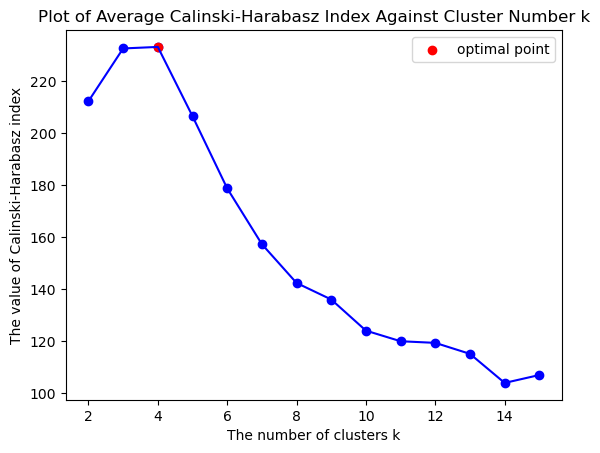

In [87]:
# plotting
plt.plot(range(2, k_range), k_range_ch_index, color="blue")
plt.scatter(range(2, k_range), k_range_ch_index, color="blue")
plt.scatter(2 + np.argmax(k_range_ch_index), np.max(k_range_ch_index), color="red", label="optimal point")
plt.xlabel("The number of clusters k")
plt.ylabel("The value of Calinski-Harabasz index")
plt.title("Plot of Average Calinski-Harabasz Index Against Cluster Number k")
plt.legend(loc = 'upper right')
plt.show()

In [88]:
# find the size of clusters found by k-means with the optimal k

opt_k = 2 + np.argmax(k_range_ch_index)
opt_centroids, opt_labels = k_clustering(gene_expression, opt_k, max_iter=70, message=True)

Iteration: 0
71.500000% labels changed
Iteration: 1
29.375000% labels changed
Iteration: 2
11.000000% labels changed
Iteration: 3
9.625000% labels changed
Iteration: 4
7.375000% labels changed
Iteration: 5
4.250000% labels changed
Iteration: 6
2.875000% labels changed
Iteration: 7
1.500000% labels changed
Iteration: 8
1.250000% labels changed
Iteration: 9
0.750000% labels changed
Iteration: 10
0.500000% labels changed
Iteration: 11
0.250000% labels changed
Iteration: 12
Labels unchanged! Terminating k-means.


In [89]:
# construct a dictionary to sum of the size for each cluster
cluster_sizes = defaultdict(int)

for i in range(opt_k):
    cluster_sizes[i] = np.sum(opt_labels==i)

print("The optimal value of k is: ", opt_k)
print("The cluster sizes found by the optimal k are: ", cluster_sizes)

The optimal value of k is:  4
The cluster sizes found by the optimal k are:  defaultdict(<class 'int'>, {0: 303, 1: 135, 2: 221, 3: 141})


#### 2.1.2 Consistency of k-means clustering

In [90]:
# optimal k from 2.1.1
opt_k = 2 + np.argmax(k_range_ch_index)

def h_score(opt_k, gene_type):
    """
    Return the average H(C) score based on optimal k
    Arg: 
        opt_k: optimal k from 2.1.1
        gene_type: true label of the gene expressions.
    """
    if type(gene_type) != np.ndarray:
        gene_type = gene_type.to_numpy()

    # initialization
    a = defaultdict(int)
    types = np.unique(gene_type)
    n = len(gene_type)
    h_c, h_ck = 0, 0
    h_c_lis, h_ck_lis = [], []

    for _ in range(5):
        up_centroids, up_labels = k_clustering(gene_expression, opt_k, max_iter=20, message=False)

        for c in types:
            for k in range(opt_k):
                a[(c, k)] = sum((gene_type==c) & (up_labels==k))

        # to compute H(c)
        for c in types:
            sig_ack = sum(a[(c, k)] for k in range(opt_k))
            h_c -= sig_ack/n * np.log(sig_ack/n)
        h_c_lis.append(h_c)
        
        # to compute H(c|k)
        for k in range(opt_k):
            sig_cck = sum(a[(j, k)] for j in types)

            # skip if 0 is encounted in the log
            for c in types:
                if a[(c, k)] != 0:
                    h_ck -= a[(c, k)]/n * np.log(a[(c, k)]/sig_cck)
        h_ck_lis.append(h_ck)

    return 1 - np.mean(h_ck_lis)/np.mean(h_c_lis)

In [91]:
# print the homogeneity score
hc = h_score(opt_k, gene_type)
print("The homogeneity score is: ", hc)

The homogeneity score is:  0.5824509972004817


# Comment:
First to note: In defining `h_score` (homogeneity score), skipped some of the nan in `a[(c, k)]`, meaning that none of the points in class c has beenclustered in cluster k. This will lead to a slight underestimation of the true homogeneity score.

By the set-up of the h_score, the higher the score, the better alignment with the original labels. From this perspective, the clustered labels are not highly consistent with the original labels.

Although `CH_k` gives the optimal clustering case, there could be some reasons for low `h_score`:

- k-measn is dependent on initialization. In this very first stage, if several points from different true classes are assigned with the same cluster label, they are likely to form an individual cluster and will affect the outcome of clustering. If time permitts, several representative samples points should be chosen as initial centroids.

- "CH_index" gives optimal clustering but necessarily the 'best' clustering. It has been shown to be sensitive to the shape of the clusters and the presence of outliers. If the initial assignments of labels give a considerable number of outliers, and they will be counted towards a certain cluster, despite the largest distance. This will consequently effect the results of centroids and thus the result of clutering. If time permits, checks for outliers and other structures of the label initialization should be implemented, and other measures of quality should be used in combination with this.

Note: the homogeneity score increases with k (shown below). This means that the greater the k, the better alignment of the clustering. But too large a k is likely to cause overfitting. Thus, the choice of k should be carefully chosen.

##### showing that homogeneity score increases with k

In [92]:
h_l = []

for k in range(2, 14):
    h_l.append(h_score(k, gene_type))

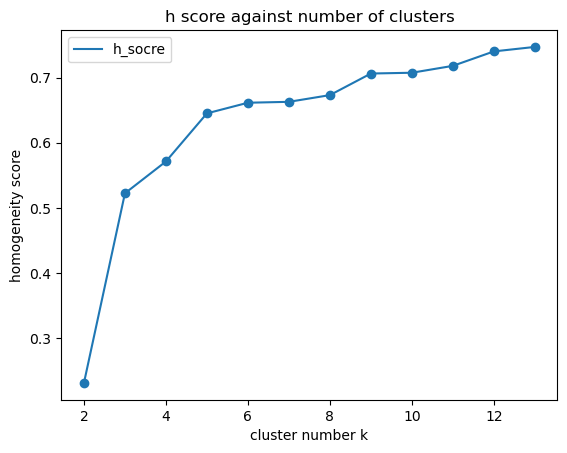

In [93]:
plt.plot(range(2, 14), h_l, label="h_socre")
plt.scatter(range(2, 14), h_l)
plt.xlabel("cluster number k")
plt.ylabel("homogeneity score")
plt.title("h score against number of clusters")
plt.legend()
plt.show()

##### results with sk.learn

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score


types = np.unique(gene_type)
c_dict = {types[i]: i for i in range(len(types))}
print(c_dict)

# Building the clustering model
kmeans = KMeans(n_clusters=opt_k)
# Training the clustering mode
kmeans.fit(gene_expression)
# Storing the predicted Clustering labels
labels = kmeans.predict(gene_expression)  
# Evaluating the performance
print(homogeneity_score(gene_type, labels))

{'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}
0.586797136972071


--------------------------------------------------------------------------------------------------------------------------------

### 2.2 Graph-based analysis (20 marks)

For a network, centrality (representative nodes), communities and modularity(degree of connections within and between communities) are topics of concern. In this section, these topics are applied and discussed.

#### 2.2.1 Imshow the adjacency matrix

In [95]:
# recall the unnormalized data: gene_data
gene_expr_22 = gene_data[gene_data.columns[:-1]].astype(float).to_numpy()
#connected correlations
cor_mat = np.corrcoef(gene_expr_22, rowvar=False)
# adjacency matrix
np.fill_diagonal(cor_mat, 0)
cor_mat[np.abs(cor_mat) < 0.75] = 0
A = cor_mat

In [96]:
print(gene_expr_22.shape)
print(cor_mat.shape)

(800, 95)
(95, 95)


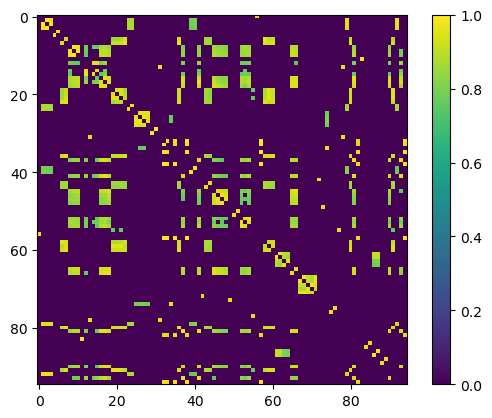

In [97]:
plt.imshow(A)
plt.colorbar();

#### 2.2.2 centrality: top 5 representative nodes

In [98]:
# degree centrality
degree = A.sum(axis=1)
sorted_index = np.argsort(degree)[::-1]
sorted_gene_expr_22 = gene_expr_22[sorted_index]

In [99]:
print("The index of the five topping ranking genes are: ", sorted_index[0:5])
print("The top 5 centralties are: ", degree[sorted_index[0:5]])
print("The top 5 ranking gene expressions are:")
for i in range(5):
    print(gene_expr_22[i])

The index of the five topping ranking genes are:  [17 41 16 81 90]
The top 5 centralties are:  [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
The top 5 ranking gene expressions are:
[ 9.79608829  0.59187087  0.59187087  0.         11.42057082 13.45375934
  4.41184652  5.41233442 10.77161327 10.22566536 10.03868584  5.51190126
  5.77501102 10.92286682  5.6050409   6.05361315  8.40630281  7.72084618
  5.74803716  7.47570912  7.15991169  5.39504909  2.47622613  3.92603738
  1.01027857 13.83498451 13.87784967 13.7711593  10.67108988  0.
  0.          9.52826851  8.82942148  7.82453875 12.21663674  9.84065835
  5.01986645  5.90279957 10.1099351   5.93902906  5.99745726  5.63479653
  7.3927639   4.26735601  2.47622613  7.67861422  4.97334034  5.04224159
  3.26629182  0.59187087 12.2261382  10.91227561 11.36228906 11.84883025
 12.08169979 10.39063115 14.19514917  8.83903683  3.01795753  6.29636379
  5.16967652 17.17356979 18.52516138 14.12612366  6.7207436   7.27775234
 10.6862

#### 2.2.3 subgraphs of the network: number of 0 eigenvalues

In [100]:
# symmetric normalized Laplacian function
def compute_l_norm(A):
    """
    Return the normalized Laplacian.
    Arg:
        A: Adjacency matrix"""

    weighted_degree = A.sum(axis=1)
    D = np.diag(weighted_degree)  # degree matrix D
    # L_norm
    weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
    D_inv_sqrt = np.diag(weighted_degree_sqrt)
    L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

    return L_norm

In [101]:
# eigen decomposition
L_norm = compute_l_norm(A)
eigenvals, eigenvecs = np.linalg.eigh(L_norm)

In [102]:
eigenvals

array([-1.25666763e-15, -1.22009119e-15, -5.86259751e-16, -2.82855538e-16,
       -2.76761826e-16, -2.26146964e-16, -1.95100938e-16, -1.49770206e-16,
       -9.98842225e-17,  4.49123519e-18,  6.31547765e-17,  2.77555756e-16,
        3.24301287e-16,  3.33281305e-16,  3.96520475e-16,  6.14434034e-16,
        7.29563077e-16,  1.13662133e-15,  4.40674341e-01,  7.09824816e-01,
        8.09205368e-01,  8.74415544e-01,  9.49448789e-01,  9.93084679e-01,
        1.00281813e+00,  1.01076222e+00,  1.02782108e+00,  1.04465433e+00,
        1.04783531e+00,  1.04956517e+00,  1.05073999e+00,  1.05146914e+00,
        1.05162853e+00,  1.05387651e+00,  1.05532375e+00,  1.05570299e+00,
        1.05633592e+00,  1.05665956e+00,  1.05968737e+00,  1.07419326e+00,
        1.07444423e+00,  1.07577484e+00,  1.07772569e+00,  1.07840825e+00,
        1.07930189e+00,  1.07966193e+00,  1.08036281e+00,  1.08130455e+00,
        1.08252594e+00,  1.08512021e+00,  1.08600827e+00,  1.09526489e+00,
        1.11444086e+00,  

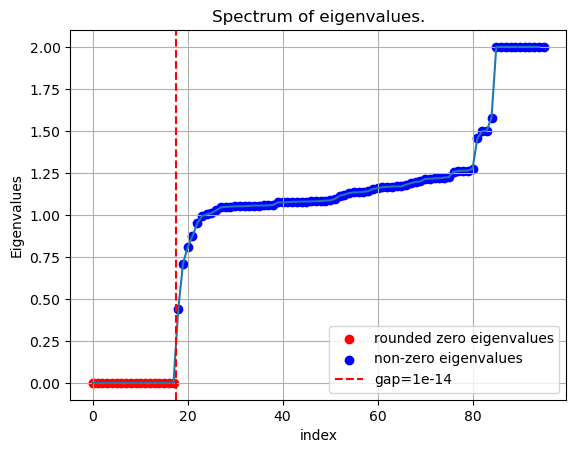

The number of zero eigenvalues is: r= 18


In [103]:
# Plotting the spectrum
r = 0
fig, ax = plt.subplots(1)
plt.plot(eigenvals)
for i in range(len(eigenvals)):
    if abs(eigenvals[i]) < 1e-14:
        plt.scatter(i, eigenvals[i], color="red")
        r += 1
    else:
        plt.scatter(i, eigenvals[i], color="blue")

plt.scatter(0, eigenvals[0], color="red", label="rounded zero eigenvalues")
plt.scatter(len(eigenvals), eigenvals[-1], color="blue", label="non-zero eigenvalues")

# gap
plt.axvline(r-0.5, color="red", linestyle="--", label="gap=1e-14")
plt.xlabel("index")
plt.ylabel("Eigenvalues")
plt.title("Spectrum of eigenvalues.")
plt.legend()
plt.grid()
plt.show()

print("The number of zero eigenvalues is: r=", r)

## Analysis:

Set the threshold as 1e-14, and round down eigenvalues smaller than it to 0. By doing so, it's obtained 18 eigenvalues are rounded down to 0 and marked red in the plot.

By lecture notes, the number of zero eigenvalues correspond to the components of the graph. Therefore, $r=18$ tells that there are 18 components consisting of the graph. In reality, it's possible that there is/are edges connecting components, but quite few.

#### 2.2.4 Elbow method: the optimal k for clustering

In this section, when finding the optimal k using elbow method, a polynomial of order 8 is fitted to the within-cluster distance:

- The loss curve is not smooth, thus determining k directly from the graph will lead to an inaccurate result.

- The order of the polynomial is adjusted through trials to give an appropriate fit to the loss but without overfitting the data.

The optimal value of k is determined at the largest k where the gradient of the loss is less than -1:

- We aim to find a point where the absolute gradient to the loss curve is decreasing to zero and, at the same time, the value of k is small. So value of -1 is chosen so that gradients after this point give absolute loss change less than 1.

In [104]:
# U
U = eigenvecs[:, :r]
# constructing T
row_norms = np.linalg.norm(U, axis=1)
D = np.diag(1/row_norms)
T = D.dot(U)

In [105]:
# define elbow function
def norm_within_cluster_dis(X, cluster_labels):
    """
    Return the w_c cost.
    Args:
        X: data set
        cluster_labels: updated cluster labels
        k: number of clusters.
    """
    w_c = 0
    for i in np.unique(cluster_labels):
        # extract the corresponding elmts
        cluster_elemts = X[cluster_labels==i, :]
        for j in cluster_elemts:
            for k in cluster_elemts:
                w_c += 0.5* np.linalg.norm(j-k)**2 / len(cluster_elemts)
    return w_c

In [106]:
# recall the k-means clustering algorithm
np.random.seed(42)
k_range = range(2, 40)
w_c = []
times = 100

# implement clustering with each k for 100 times and choose the one with minimal cost
for k in k_range:
    holding_l = []
    for i in range(times):
        up_centroids, up_labels = k_clustering(T, k, max_iter=100, message=False)
        holding_l.append(norm_within_cluster_dis(T, up_labels))
    wc_cost = np.min(holding_l)
    w_c.append(wc_cost)


In [107]:
# the within-cluster distance cost
print(w_c)

[64.61111111110448, 51.07142857143121, 42.851063829786696, 36.34999999999901, 33.05128205128229, 26.324110671936715, 23.780219780219834, 21.303030303030248, 17.76923076923074, 15.000000000000021, 13.111111111111118, 11.399999999999991, 8.857142857142863, 6.400000000000001, 4.4, 4.0, 3.9999999999999982, 3.1111111111111125, 1.9999999999999991, 2.0, 9.4374449716689e-29, 1.9999999999999996, 9.335365708757868e-29, 8.914833625882453e-29, 8.627403593411206e-29, 8.732139564492352e-29, 7.975464815141715e-29, 8.544480761022826e-29, 7.987259597634385e-29, 7.971117744695417e-29, 8.244491999274519e-29, 7.560213599202927e-29, 7.12001438346075e-29, 7.246370752697711e-29, 6.970868871646457e-29, 6.955285149371518e-29, 6.244727734560932e-29, 6.136287568266725e-29]


##### elbow method: seeting an epsilon

For elbow method, we want to tradeoff between k and the cost-- a `k` such that the cost is low while the `k` is small as well.

From lecture notes, the elbow curve is deceasing fast and then the decreasing rate slows down and finally remains almost stable. The elbow point is set at the 'middle' change-phase ie. the region where the curve's decreasing rate is slowing down.

Therefore, a tolerance `eps` should be set and adjusted through trials. (Intuitively from the plot, we should expect that it falls between 12-20.)

In [108]:
eps = 2  # tolerance
for i in range(len(w_c)):
    if w_c[i] <= eps:
        elbow_k = i + 2
        print("The elbow k is: ", elbow_k)
        print("The cost is: ", w_c[i])
        break

The elbow k is:  20
The cost is:  1.9999999999999991


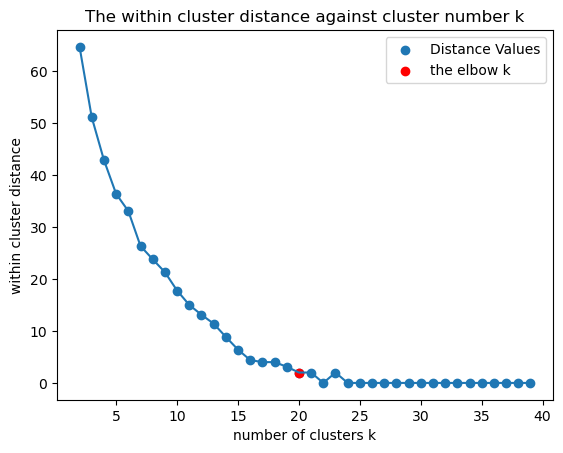

In [109]:
plt.plot(k_range, w_c)
plt.scatter(k_range, w_c, label='Distance Values')
plt.scatter(elbow_k, w_c[elbow_k-2], color="red", label="the elbow k")
plt.legend()
plt.xlabel("number of clusters k")
plt.ylabel("within cluster distance")
plt.title("The within cluster distance against cluster number k")
plt.show()

In [110]:
# obtain clustering for the optimal k
np.random.seed(4)
centroids, labels = k_clustering(T, elbow_k, max_iter=100, message=True)

# construct a dictionary to hold the indexes of points for each label
cluster_dict = defaultdict(list)
for i in range(elbow_k):
    cluster_dict[i].extend(list(np.where(labels==i)[0]))

print("The value of k at the elbow point is: ", elbow_k)
print("The clustering by elbow k: ", cluster_dict)

Iteration: 0
72.631579% labels changed
Iteration: 1
Labels unchanged! Terminating k-means.
The value of k at the elbow point is:  20
The clustering by elbow k:  defaultdict(<class 'list'>, {0: [], 1: [84, 85], 2: [49, 73], 3: [29, 30, 50, 51], 4: [6, 7, 19, 20, 21, 22, 36, 43, 44, 55, 58, 59, 60, 77, 80, 91], 5: [8, 9, 10, 12, 14, 15, 16, 17, 18, 37, 41, 45, 46, 47, 48, 52, 53, 54, 65, 66, 81, 90, 93], 6: [1, 2, 3, 23, 24, 39, 40, 79, 92], 7: [0, 56, 75, 76], 8: [], 9: [25, 26, 27, 28, 34, 74], 10: [], 11: [42, 61, 62, 63, 64, 72, 86, 87], 12: [4, 5], 13: [], 14: [11, 13, 31, 78, 83], 15: [67, 68, 69, 70, 71], 16: [], 17: [32, 33, 35, 38, 57, 82, 94], 18: [88, 89], 19: []})


In [111]:
# define a function to catch the size of the clusters of T
def cluster_size(cluster_dict):
    """
    Return the sizes of each cluster of T.
    """
    size_dict = defaultdict(int)
    for i in cluster_dict:
        size_dict[i] = len(cluster_dict[i])

    return size_dict

size_dict = cluster_size(cluster_dict)
print("The size of each cluster by elbow k is: ", size_dict)

The size of each cluster by elbow k is:  defaultdict(<class 'int'>, {0: 0, 1: 2, 2: 2, 3: 4, 4: 16, 5: 23, 6: 9, 7: 4, 8: 0, 9: 6, 10: 0, 11: 8, 12: 2, 13: 0, 14: 5, 15: 5, 16: 0, 17: 7, 18: 2, 19: 0})


# Interpretation to the graph structure:

- The appropriateness of elbow k:

By seeting a tolerance `eps`, elbow k is found at `k==20`. Each column of `T` is an eigenvector corresponds to a unique subgraph of the original network. Therefore, clustering T should give an optimal k close to `r=18`. The k found by elbow problem makes sense from this perspective.

- construction & clustering of T:

The construction of `T` is equivalent to projecting the nodes into a lower dimensional space (dim=18 in this case)

Similar to clustering implemented in coursework 1, clusters found have smallest total within-cluster distance and greatest total inter-cluster diatances. And these two criteria are substituted by connectivity: as many as within-cluster edges and as less as inter-cluster edges. Implementing k-means clustering, we found that some of the labels have zero samples clustered in that cluster, and this is because the update of labels with the change of centroids in each iteration of k-means algorithm.

The clustering of T provides an insight into the modularity(how clusters connect) of the network. For `T`:

$\cdot$ each row represents the behavior of a node in these zero eigen-spaces. By clustering results, there are 14 clusters of similar behavior of the nodes, where each cluster is densely connedted within itself and sparsely connected with other clusters. This gives an insight of which of the features of the genes are more connected and which are not.

- clustering by T & by 2.1.3:

By 2.1.3, there are 18 clusters. But for the result of clustering of T, there are 14 non-empty clusters and 6 empty clusters. This means that some of clusters must have been merged to form a bigger one in kmeans clustering. Recall the process of updating centroids of each cluster and reassigning labels--bigger clusters tend to drag small clusters and merge them as they are a main force of dragging the centoids. In terms of the graph structure, some small clusters are more connected to bigger ones,
eg. the cluster labelled 1 can be more likely to be more attached to the cluster labelled 4.

#### 2.2.5: Spectral partitioning and binary partition of the biggest subgraph

In [112]:
# get the largest cluster and corresponding node indices
largest_cluster = list(size_dict.keys())[np.argmax(list(size_dict.values()))]
largest_cluster_indices = cluster_dict[largest_cluster]
# get subgraph and corresponding adjcency matrix
mask = (labels == largest_cluster)
sub_A = A[mask,:][:,mask]
# corresponding indexes of the original network
mask_indx = np.where(mask==True)

# get sub_Lagrangian
sub_L_norm = compute_l_norm(sub_A)
sub_eigenvals, sub_eigenvecs = np.linalg.eigh(sub_L_norm)
# perform binary spectral partition
second_index = np.where(sub_eigenvals>1e-7)[0][0] # first nontrivial index
spectral_partition = sub_eigenvecs[:,second_index]
spectral_partition[spectral_partition<0] = 0 
spectral_partition[spectral_partition>0] = 1 


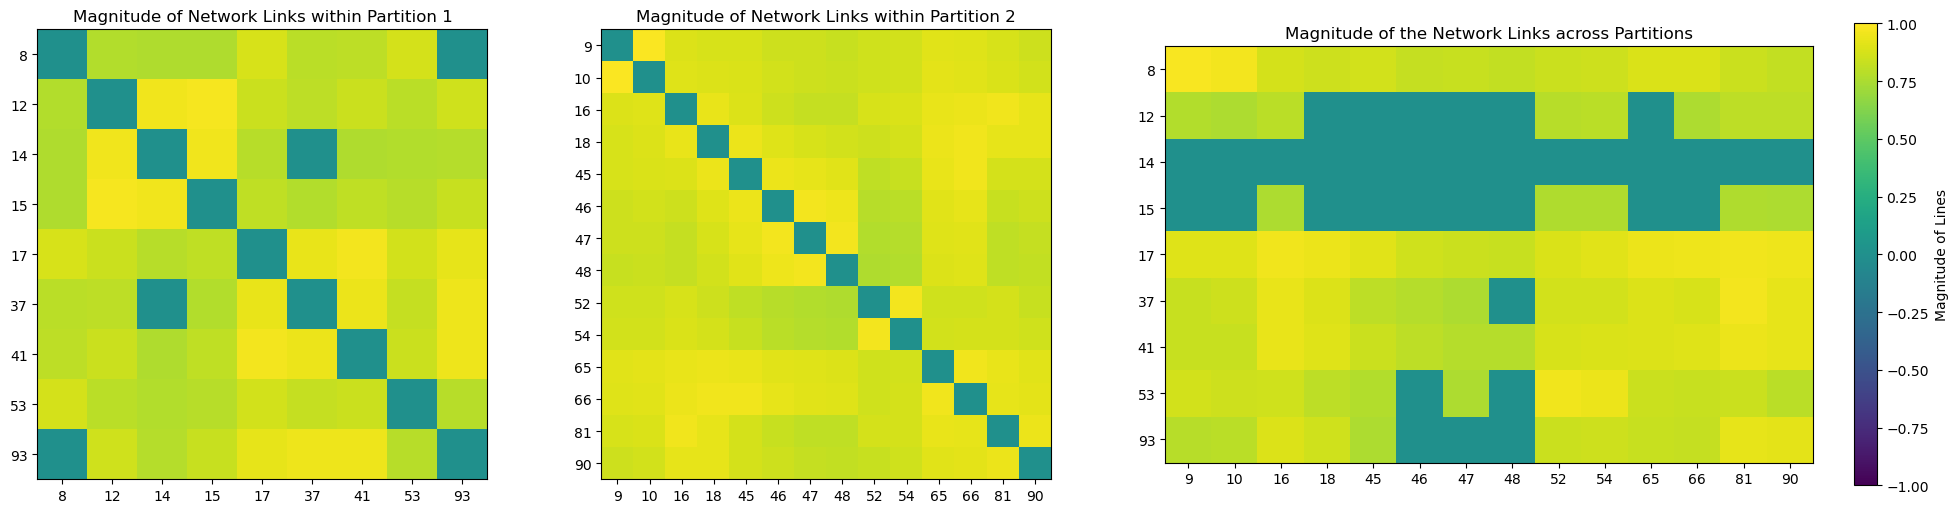

In [113]:
p1 = np.where(spectral_partition == 0)[0]
p2 = np.where(spectral_partition == 1)[0]
n1 = len(p1)
n2 = len(p2)

# Define the ratios for the subplots
width_ratios = [1, 1, 1.8]
# Create the figure and the grid
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(1, 3, width_ratios=width_ratios)

# first plot
ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(sub_A[p1,:][:,p1], cmap='viridis', vmin=-1, vmax=1)
ax0.set_xticks(np.arange(n1))
ax0.set_yticks(np.arange(n1))
ax0.set_xticklabels(np.array(largest_cluster_indices)[p1])
ax0.set_yticklabels(np.array(largest_cluster_indices)[p1])
ax0.set_title('Magnitude of Network Links within Partition 1')

# second plot
ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(sub_A[p2,:][:,p2], cmap='viridis', vmin=-1, vmax=1)
ax1.set_xticks(np.arange(n2))
ax1.set_yticks(np.arange(n2))
ax1.set_xticklabels(np.array(largest_cluster_indices)[p2])
ax1.set_yticklabels(np.array(largest_cluster_indices)[p2])
ax1.set_title('Magnitude of Network Links within Partition 2')

# third plot
ax2 = plt.subplot(gs[2])
im2 = ax2.imshow(sub_A[p1,:][:,p2], cmap='viridis', vmin=-1, vmax=1)
ax2.set_xticks(np.arange(n2))
ax2.set_yticks(np.arange(n1))
ax2.set_xticklabels(np.array(largest_cluster_indices)[p2])
ax2.set_yticklabels(np.array(largest_cluster_indices)[p1])
ax2.set_title('Magnitude of the Network Links across Partitions')

# Add a color bar
cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.4)
cbar2.set_label('Magnitude of Lines')

# Show the plot
plt.show()


# Comment on the pattern:

A corresponding network graph is plotted below.

within partitions:

- partition 1: any node is connected with other nodes with a single edge except the pair (37, 14) and (93, 8)
- partition 2: all nodes are connected with a single edge
- Comparing two individual partitions, partition 2 is more closely connected, which can be confirmed with the partial graph below connected in blue.

across partitions:

- not all the nodes are directly connected with a single edge. Particularly, node 14 in partition 1 is sparsely connected with all nodes in partition 2 with a single edge, which corresponds to the farthest red node in the network graph below. 
- node 12 and 14 in partition 1 are also sparsely connected to partition 2, with a few connected edges. They correspond to the red nodes at the 'boundaries' of 2 partitions. Similarly, node 46, 47 and 48 correspond to the blue nodes at the partition boundary, as they are only sinply connected to a few nodes in partition 1.
- node 37 in partition 1 is sparsely connected with node 48 in partition 2

##### compliment to the analysis

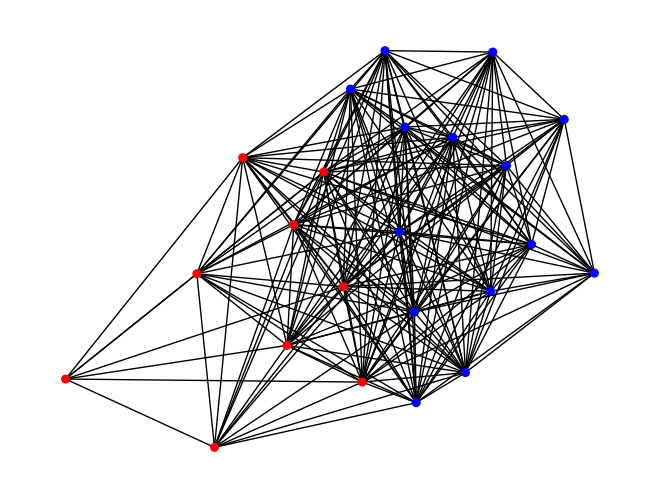

In [114]:
# drawing networkx graph of sub_A, and coloring partitions with 2 colors
g = nx.Graph(sub_A)
colored_nodes = p1
node_colors = ['red' if node in colored_nodes else 'blue' for node in g.nodes()]
nx.draw(g, node_size=30, node_color=node_colors)

#### 2.2.6 Centralities of the subgraph

In [115]:
# degree centrality
sub_degree = sub_A.sum(axis=1)
sub_sorted_index = np.argsort(sub_degree)[::-1]
sub_sorted_gene_expr_22 = gene_expr_22[sub_sorted_index]
print("The index of the five topping ranking genes are: ", mask_indx[0][sub_sorted_index[0:5]])
print("The top 5 centralities are: ", sub_degree[sub_sorted_index[0:5]])
print("The top 5 ranking gene expressions are:",)
for i in range(5):
    print(sub_sorted_gene_expr_22[i])

The index of the five topping ranking genes are:  [17 41 16 81 90]
The top 5 centralities are:  [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
The top 5 ranking gene expressions are:
[ 8.92200751  1.65526023  0.44180215  0.         12.06016901 13.67437988
  4.39674177  4.42107515 11.38857703 10.95483607 10.92828889  8.57963273
  7.98435579 11.33975538  7.18736197  8.85325653 10.24577848  9.43419452
  7.63761749  5.20278991  5.1010365   5.31091447  2.96487914  2.89710486
  1.48104056 15.29502989 16.03244183 14.99020592 12.31127434  0.
  0.          9.66501785  7.91964995  6.48955899 15.18833385 10.71144328
  3.41602901  8.27041214  9.32156512  6.09506783  4.76317252  8.31978049
  8.32314035  4.62336356  3.63985727  8.95049758  4.28954678  4.89062179
  3.0296119   0.7795539   9.9098121   7.53265203 12.89064048 12.39811037
 13.96305862  9.58934029 13.53431504  9.87500439  3.0296119   4.7820835
  4.53694187 15.74874843 17.60456047 14.13791172  7.20498189  8.82161775
 11.6552

In [116]:
print("The index of the top 5 ranking genes are: ", sorted_index[0:5])
print("The centralities of top 5 gene expressions of the A are:", degree[sorted_index[0:5]])
print("The index of the top 5 ranking genes are: ", mask_indx[0][sub_sorted_index[0:5]])
print("The centralities of top 5 gene expressions of the sub_A are:", sub_degree[sub_sorted_index[0:5]])

The index of the top 5 ranking genes are:  [17 41 16 81 90]
The centralities of top 5 gene expressions of the A are: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
The index of the top 5 ranking genes are:  [17 41 16 81 90]
The centralities of top 5 gene expressions of the sub_A are: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


# Analysis:

|| 17 | 41 | 16 | 81 | 90
|----------|----------|----------|----------|----------|----------|
| centrality of original graph | 19.73839866 | 19.04945567 | 18.64028395 | 18.53179044 | 18.2670517 
| centrality of the sub graph | 19.73839866 | 19.04945567 | 18.64028395 | 18.53179044 | 18.2670517 

By the printed result above, the top 5 degree centrality of the sub graph remain identical to the orignal network.

This makes sense by the way we found the elbow k, and the biggest cluster:
- The elbow k is found by the minimal cost of 100 iterations of each k and among a range of k, guaranteed the 'best' clustering of the graph as possibly. After this step, nodes with more edges connected to each other are more likely to be clustered as a subgraph.
- The subgraph is constructed from the biggest cluster from the clusters found by the optimal k, which is, at the highest possibility, the most densely knitted subgraph of the network.

The centrality of a network indicates the importance of each node: the higher the centrality, the more representative of a node.
Therefore, the top 5 centralities of the subgraph is expected to be identical to be the global top 5 centralities of the original network.

##### That's all. Thanks for your reading!

## Task 3: Mastery component  (25 marks)

**Please delete this section if you are not a master student**

